# Building permutation invariant Sparse GPs

Okay, so the final piece of the puzzle regarding extending the PIICM is dealing with the invariance. Remember that in the original PIICM model, the GP was a function of 5 parameters
$$
f(c,A,B,x_A,x_B),
$$
the cell line $c$, the drugs $A$ and $B$ and the corresponding concentrations $x_A$ and $x_B$. The PIICM was invariant to the ordering of the drugs and their concentrations, so the following equality was enforced

$$
f(c,A,B,x_A,x_B)=f(c,B,A,x_B,x_A).
$$

This is done by constructing the GP via a summation. Construct the function $f()$ as the sum of evaluations of another function $\tilde{f}()$ like so:

$$
f(c,A,B,x_A,x_B) = \tilde{f}(c,A,B,x_A,x_B) + \tilde{f}(c,B,A,x_B,x_A),
$$
then placing a GP prior on $\tilde{f}$ induces a GP prior on $f$ itself since GPs are closed under summations. Note that the mapping of inputs $(c,A,B,x_A,x_B)\mapsto (c,B,A,x_B,x_A)$ leaves the function $f$ unchanged. If $\tilde{f}\sim\mathcal{GP}(0,\tilde{\kappa}(\cdot,\cdot))$, the induced GP prior has a covariance function

$$
\begin{align}
\text{Cov}\left[f(c,A,B,x_A,x_B),f(c',A',B',x'_A,x'_B)\right]  &= 
\text{Cov}[\tilde{f}(c,A,B,x_A,x_B) + \tilde{f}(c,B,A,x_B,x_A),\tilde{f}(c',A',B',x'_A,x'_B) + \tilde{f}(c',B',A',x'_B,x'_A)] \\
&=\text{Cov}\left[\tilde{f}(c,A,B,x_A,x_B),\tilde{f}(c',A',B',x'_A,x'_B)\right] + 
  \text{Cov}\left[\tilde{f}(c,A,B,x_A,x_B),\tilde{f}(c',B',A',x'_B,x'_A)\right] \\
  &+ 
  \text{Cov}\left[\tilde{f}(c,B,A,x_B,x_A),\tilde{f}(c',A',B',x'_A,x'_B)\right] + 
  \text{Cov}\left[\tilde{f}(c,B,A,x_B,x_A),\tilde{f}(c',B',A',x'_B,x'_A)\right] \\
&=\tilde{\kappa}((c,A,B,x_A,x_B),(c',A',B',x'_A,x'_B))+
  \tilde{\kappa}((c,A,B,x_A,x_B),(c',B',A',x'_B,x'_A))\\
  &+
  \tilde{\kappa}((c,B,A,x_B,x_A),(c',A',B',x'_A,x'_B))+
  \tilde{\kappa}((c,B,A,x_B,x_A),(c',B',A',x'_B,x'_A)).
\end{align}
$$

## Sparse approximation

When working with inducing points, we need to think of where to place them. In the case of invariant GPs, one can be quite efficient with them as symmetries are naturally built into the kernel. The key is to approximate $\tilde{f}$ with inducing variables and not $f$ itself. The question is how do we do this within the SVI framework in GPyTorch?

Placing inducing variables in $\tilde{f}$ (instead of $f$) is sometimes referred to as *inter-domain inducing variables* (see e.g. references by Mark van der Wilk and others [1](https://arxiv.org/pdf/2003.01115.pdf), [2](https://proceedings.neurips.cc/paper_files/paper/2018/file/d465f14a648b3d0a1faa6f447e526c60-Paper.pdf)). I might need to work through the maths here again to make sure I understand it. It needs specifying a slightly different bound, but it is essentially the same as the old one with some modification to the kernels.

From the programming side of things, I wonder if it is simply a matter of modifying the `forward` method of the underlying models, as presumably that's where the covariances are generated from. Curious to see how the bound is evaluated though, as e.g. $\text{Cov}[f(x),\tilde{f}(z)]$ would contain a "single sum", while $\text{Cov}[f(x),f(x')]$ would contain a "double sum" in the language of van der Wilk.

Specifically, if we assume $\tilde{f}$ is defined over some space $\mathcal{Z}$ and $f$ over the space $\mathcal{X}$ then

$$
\begin{align}
\text{Cov}[f(\mathbf{x}),f(\mathbf{x}')] &= \kappa(\mathbf{x},\mathbf{x}') + \kappa(\mathbf{x},\tilde{\mathbf{x}}') + \kappa(\tilde{\mathbf{x}},\mathbf{x}') + \kappa(\tilde{\mathbf{x}},\tilde{\mathbf{x}}') \\
\text{Cov}[f(\mathbf{x}),\tilde{f}(\mathbf{z}')] &= \kappa(\mathbf{x},\mathbf{z}') + \kappa(\tilde{\mathbf{x}},\mathbf{z}') \\
\text{Cov}[\tilde{f}(\mathbf{z}),\tilde{f}(\mathbf{z}')] &= \kappa(\mathbf{z},\mathbf{z}')
\end{align}
$$

I think the relevant piece of code in `VariationalStrategy.forward` is 

```{python}
# Compute full prior distribution
full_inputs = torch.cat([inducing_points, x], dim=-2)
full_output = self.model.forward(full_inputs, **kwargs)
full_covar = full_output.lazy_covariance_matrix
```

Which calls `forward` of the model (of class `ApproximateGP`), on both the inputs $X$ and the inducing locations $Z$. But these should now have a different covariance, so I need to modify this.

## A very basic Sparse GP implementation

Below I set up a very basic implementation of Sparse GPs with SVI. Basically, I just want to follow Hensman (2015) and get a framework up that I can experiment with. The function needs to be a function of two inputs, $f(x_1,x_2)$ and I'll try to enforce $f(x_1,x_2)=f(x_2,x_1)$ which will lead to symmetric contour plots.

With this restriction in place, it means the covariance of $f$ will take the form

$$
\kappa((x_1,x_2),(x_1',x_2')) = \kappa((x_1,x_2),(x_1',x_2')) + \kappa((x_1,x_2),(x_2',x_1')) + \kappa((x_2,x_1),(x_1',x_2')) + \kappa((x_2,x_1),(x_2',x_1'))
$$

I generate true data from this distribtution, but set up a vanilla SVI model to estimate it, not taking the invariance into account. In order to really visualize the failure of the GP to capture this, I'll furthermore simulate data very sparsely, making it difficult for the GP to learn the invariance simply through the data.

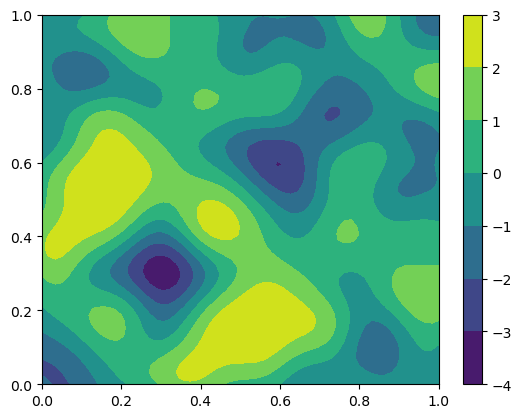

In [1]:
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

# Setting up the grid
n = 60
x1 = torch.linspace(0,1,n)
x2 = torch.linspace(0,1,n)
x1_grid, x2_grid = torch.meshgrid(x1,x2,indexing='ij')
X1 = x1_grid.reshape(-1)
X2 = x2_grid.reshape(-1)
X = torch.stack([X1,X2],dim=-1)
X_flipped = torch.stack([X2,X1],dim=-1)

# Generating a random sample from a GP
mean = gpytorch.means.ZeroMean()
covar = gpytorch.kernels.RBFKernel()
covar.lengthscale = 0.1
m = mean(X)
K = (covar(X,X) + covar(X,X_flipped) + covar(X_flipped,X) + covar(X_flipped,X_flipped)).add_jitter().evaluate()
GP = gpytorch.distributions.MultivariateNormal(m,K)
f = GP.rsample().detach()


# Now generate some corresponding data
sigma = 0.01
y = f + sigma*torch.randn(f.size())


# Finally, going to drop a proportion of the data just to ensure the grid structure is broken and 
# the model will find it difficult to learn the exact invariance.
k = 2000
perm = torch.randperm(y.size(0))
idx = perm[:k]
y = y[idx]
X = X[idx,:]


plt.contourf(x1_grid.numpy(),x2_grid.numpy(),f.reshape(x1_grid.shape))
plt.colorbar()



In [2]:
# And now define the approximate model, nothing invariant going on here
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(self,inducing_points,variational_distribution, learn_inducing_locations=True)
        super(GPModel,self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)
    
num_inducing_points = 100
inducing_points = torch.rand(num_inducing_points,2)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [3]:
# Set up optimization scheme

# Number of iterations of optimizer
training_iter = 4000

# Set model in train
model.train()
likelihood.train()
# Optimizeer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)
# Define loss function
mll = gpytorch.mlls.VariationalELBO(likelihood,model,num_data = y.size(0))

# Keeping track of loss
m = []
eps = 1e-4
diff = 10

# Then train
for i in range(training_iter):
    # Zero gradients
    optimizer.zero_grad()
    # Output from model 
    output = model(X)
    # Calculate loss
    loss = -mll(output,y)
    loss.backward()
    m.append(loss.item())
    if i > 0:
        diff = abs(m[i]-m[i-1])
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f loss difference: %.4f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        likelihood.noise.item(),
        diff
    ))
    optimizer.step()
    if diff < eps:
        print('Model converged!')
        break

Iter 1/4000 - Loss: 2.477   lengthscale: 0.693   noise: 0.693 loss difference: 10.0000
Iter 2/4000 - Loss: 2.439   lengthscale: 0.698   noise: 0.698 loss difference: 0.0379
Iter 3/4000 - Loss: 2.402   lengthscale: 0.695   noise: 0.703 loss difference: 0.0373
Iter 4/4000 - Loss: 2.365   lengthscale: 0.690   noise: 0.708 loss difference: 0.0367
Iter 5/4000 - Loss: 2.329   lengthscale: 0.686   noise: 0.713 loss difference: 0.0358
Iter 6/4000 - Loss: 2.294   lengthscale: 0.682   noise: 0.718 loss difference: 0.0351
Iter 7/4000 - Loss: 2.260   lengthscale: 0.677   noise: 0.724 loss difference: 0.0343
Iter 8/4000 - Loss: 2.226   lengthscale: 0.672   noise: 0.729 loss difference: 0.0334
Iter 9/4000 - Loss: 2.194   lengthscale: 0.668   noise: 0.734 loss difference: 0.0326
Iter 10/4000 - Loss: 2.162   lengthscale: 0.663   noise: 0.739 loss difference: 0.0313
Iter 11/4000 - Loss: 2.132   lengthscale: 0.658   noise: 0.744 loss difference: 0.0302
Iter 12/4000 - Loss: 2.103   lengthscale: 0.653   n

Iter 101/4000 - Loss: 1.423   lengthscale: 0.273   noise: 1.014 loss difference: 0.0084
Iter 102/4000 - Loss: 1.413   lengthscale: 0.269   noise: 1.015 loss difference: 0.0102
Iter 103/4000 - Loss: 1.405   lengthscale: 0.265   noise: 1.015 loss difference: 0.0080
Iter 104/4000 - Loss: 1.396   lengthscale: 0.261   noise: 1.015 loss difference: 0.0088
Iter 105/4000 - Loss: 1.388   lengthscale: 0.257   noise: 1.015 loss difference: 0.0076
Iter 106/4000 - Loss: 1.387   lengthscale: 0.253   noise: 1.015 loss difference: 0.0008
Iter 107/4000 - Loss: 1.392   lengthscale: 0.249   noise: 1.015 loss difference: 0.0045
Iter 108/4000 - Loss: 1.366   lengthscale: 0.245   noise: 1.015 loss difference: 0.0259
Iter 109/4000 - Loss: 1.370   lengthscale: 0.241   noise: 1.015 loss difference: 0.0039
Iter 110/4000 - Loss: 1.355   lengthscale: 0.237   noise: 1.014 loss difference: 0.0144
Iter 111/4000 - Loss: 1.348   lengthscale: 0.234   noise: 1.014 loss difference: 0.0071
Iter 112/4000 - Loss: 1.338   le

Iter 199/4000 - Loss: 0.920   lengthscale: 0.124   noise: 0.689 loss difference: 0.0014
Iter 200/4000 - Loss: 0.913   lengthscale: 0.123   noise: 0.685 loss difference: 0.0064
Iter 201/4000 - Loss: 0.911   lengthscale: 0.123   noise: 0.680 loss difference: 0.0017
Iter 202/4000 - Loss: 0.907   lengthscale: 0.123   noise: 0.675 loss difference: 0.0047
Iter 203/4000 - Loss: 0.903   lengthscale: 0.123   noise: 0.670 loss difference: 0.0034
Iter 204/4000 - Loss: 0.900   lengthscale: 0.123   noise: 0.665 loss difference: 0.0037
Iter 205/4000 - Loss: 0.896   lengthscale: 0.123   noise: 0.660 loss difference: 0.0039
Iter 206/4000 - Loss: 0.893   lengthscale: 0.123   noise: 0.656 loss difference: 0.0032
Iter 207/4000 - Loss: 0.889   lengthscale: 0.122   noise: 0.651 loss difference: 0.0037
Iter 208/4000 - Loss: 0.885   lengthscale: 0.122   noise: 0.646 loss difference: 0.0036
Iter 209/4000 - Loss: 0.881   lengthscale: 0.122   noise: 0.641 loss difference: 0.0042
Iter 210/4000 - Loss: 0.878   le

Iter 298/4000 - Loss: 0.545   lengthscale: 0.116   noise: 0.297 loss difference: 0.0005
Iter 299/4000 - Loss: 0.543   lengthscale: 0.116   noise: 0.294 loss difference: 0.0021
Iter 300/4000 - Loss: 0.539   lengthscale: 0.116   noise: 0.292 loss difference: 0.0043
Iter 301/4000 - Loss: 0.535   lengthscale: 0.116   noise: 0.289 loss difference: 0.0039
Iter 302/4000 - Loss: 0.530   lengthscale: 0.116   noise: 0.286 loss difference: 0.0048
Iter 303/4000 - Loss: 0.524   lengthscale: 0.116   noise: 0.284 loss difference: 0.0058
Iter 304/4000 - Loss: 0.518   lengthscale: 0.116   noise: 0.281 loss difference: 0.0061
Iter 305/4000 - Loss: 0.514   lengthscale: 0.116   noise: 0.278 loss difference: 0.0043
Iter 306/4000 - Loss: 0.510   lengthscale: 0.116   noise: 0.276 loss difference: 0.0034
Iter 307/4000 - Loss: 0.507   lengthscale: 0.116   noise: 0.273 loss difference: 0.0037
Iter 308/4000 - Loss: 0.502   lengthscale: 0.116   noise: 0.270 loss difference: 0.0045
Iter 309/4000 - Loss: 0.497   le

Iter 398/4000 - Loss: 0.179   lengthscale: 0.112   noise: 0.120 loss difference: 0.0034
Iter 399/4000 - Loss: 0.173   lengthscale: 0.112   noise: 0.119 loss difference: 0.0060
Iter 400/4000 - Loss: 0.170   lengthscale: 0.112   noise: 0.118 loss difference: 0.0030
Iter 401/4000 - Loss: 0.181   lengthscale: 0.112   noise: 0.117 loss difference: 0.0107
Iter 402/4000 - Loss: 0.176   lengthscale: 0.112   noise: 0.116 loss difference: 0.0046
Iter 403/4000 - Loss: 0.168   lengthscale: 0.112   noise: 0.115 loss difference: 0.0085
Iter 404/4000 - Loss: 0.160   lengthscale: 0.112   noise: 0.114 loss difference: 0.0078
Iter 405/4000 - Loss: 0.154   lengthscale: 0.112   noise: 0.113 loss difference: 0.0055
Iter 406/4000 - Loss: 0.153   lengthscale: 0.112   noise: 0.111 loss difference: 0.0012
Iter 407/4000 - Loss: 0.146   lengthscale: 0.112   noise: 0.110 loss difference: 0.0074
Iter 408/4000 - Loss: 0.144   lengthscale: 0.112   noise: 0.109 loss difference: 0.0017
Iter 409/4000 - Loss: 0.138   le

False


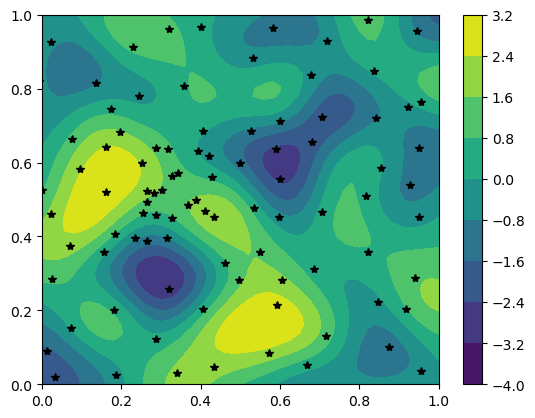

In [4]:
# Now making predictions on a finer grid
# Setting up the grid
n = 51
x1_test = torch.linspace(0,1,n)
x2_test = torch.linspace(0,1,n)
x1_test_grid, x2_test_grid = torch.meshgrid(x1_test,x2_test,indexing='ij')
X1_test = x1_test_grid.reshape(-1)
X2_test = x2_test_grid.reshape(-1)
X_test = torch.stack([X1_test,X2_test],dim=-1)
X_test_flipped = torch.stack([X2_test,X1_test],dim=-1)


# Get model into eval mode
model.eval()
likelihood.eval()

# Predicting
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))
    observed_pred_flipped = likelihood(model(X_test_flipped))


# Testing if predictions are equal
mean = observed_pred.mean
mean_flipped = observed_pred_flipped.mean
print(torch.equal(mean,mean_flipped)) # This returns False

# Plotting 
plt.contourf(x1_test_grid.numpy(),x2_test_grid.numpy(),mean.reshape(x1_test_grid.shape))
plt.colorbar()
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(model.variational_strategy.inducing_points.detach()[:,0],model.variational_strategy.inducing_points.detach()[:,1],'k*')

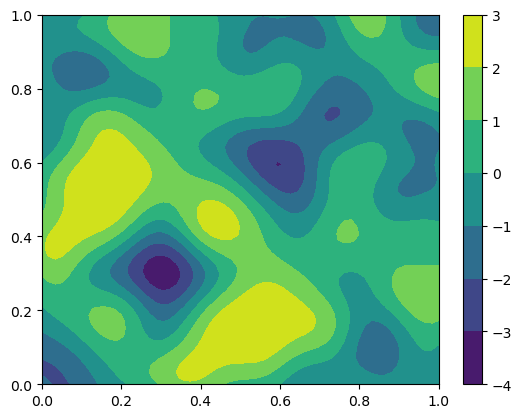

In [5]:
# Versus the true function

plt.contourf(x1_grid.numpy(),x2_grid.numpy(),f.reshape(x1_grid.shape))
plt.colorbar()

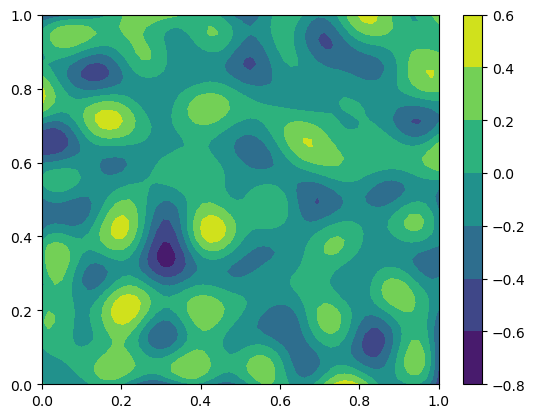

In [6]:
# And finally, let's look at the error surface
X_train_test = torch.stack([X1,X2],dim=-1)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_at_train = likelihood(model(X_train_test))

mean = test_at_train.mean
error = f-mean
plt.contourf(x1_grid.numpy(),x2_grid.numpy(),error.reshape(x1_grid.shape))
plt.colorbar()

## A first attempt at building in permutation invariance
Okay, so of course this does not work. While the model is flexible, and sometimes capable of learning the invariance itself, it is not strongly enforced. In order to do this, we need to modify the model to take this invariance into account. I need to understand how the invariance changes the ELBO and the variational distribution, and then I need to understand how to modify the corresponding terms in the `VariationalStrategy` or in the model itself.

In [7]:
# Lets first set up our own Variational Strategy, just so we can see the flow of things:
# just copy and paste in the default one with a new name:
from typing import  Any, Dict, Iterable, Optional, Tuple
from torch import Tensor
from linear_operator import to_dense
from linear_operator.operators import (
    CholLinearOperator,
    DiagLinearOperator,
    LinearOperator,
    MatmulLinearOperator,
    RootLinearOperator,
    SumLinearOperator,
    TriangularLinearOperator,
)
from linear_operator.utils.cholesky import psd_safe_cholesky
from linear_operator.utils.errors import NotPSDError
from gpytorch.distributions import MultivariateNormal
from gpytorch.settings import _linalg_dtype_cholesky, trace_mode

def _ensure_updated_strategy_flag_set(
    state_dict: Dict[str, Tensor],
    prefix: str,
    local_metadata: Dict[str, Any],
    strict: bool,
    missing_keys: Iterable[str],
    unexpected_keys: Iterable[str],
    error_msgs: Iterable[str],
):
    device = state_dict[list(state_dict.keys())[0]].device
    if prefix + "updated_strategy" not in state_dict:
        state_dict[prefix + "updated_strategy"] = torch.tensor(False, device=device)
        warnings.warn(
            "You have loaded a variational GP model (using `VariationalStrategy`) from a previous version of "
            "GPyTorch. We have updated the parameters of your model to work with the new version of "
            "`VariationalStrategy` that uses whitened parameters.\nYour model will work as expected, but we "
            "recommend that you re-save your model.",
            OldVersionWarning,
        )

class PermutationInvariantVariationalStrategy(gpytorch.variational.VariationalStrategy):
    def __init__(self,
        model: gpytorch.models.ApproximateGP,
        inducing_points: torch.Tensor,
        variational_distribution: gpytorch.variational._VariationalDistribution,
        learn_inducing_locations: bool = True,
        jitter_val: Optional[float] = None,
    ):
        super().__init__(
            model, inducing_points, variational_distribution, learn_inducing_locations, jitter_val=jitter_val
        )
        self.register_buffer("updated_strategy", torch.tensor(True))
        self._register_load_state_dict_pre_hook(_ensure_updated_strategy_flag_set)
        self.has_fantasy_strategy = True
    
    def forward(
        self,
        x: Tensor,
        inducing_points: Tensor,
        inducing_values: Tensor,
        variational_inducing_covar: Optional[LinearOperator] = None,
        **kwargs,
    ) -> MultivariateNormal:
        # Compute full prior distribution
        full_inputs = torch.cat([inducing_points, x], dim=-2)
        full_inputs_flipped = torch.cat([inducing_points, x.flip(-1)],dim=-2)
        full_inputs_flipped_flipped = torch.cat([x,x.flip(-1)],dim=-2)
        full_output = self.model.forward(full_inputs, **kwargs)
        full_output_flipped = self.model.forward(full_inputs_flipped, **kwargs)
        full_output_flipped_flipped = self.model.forward(full_inputs_flipped_flipped, **kwargs)
        full_covar = full_output.lazy_covariance_matrix
        full_covar_flipped = full_output_flipped.lazy_covariance_matrix
        full_covar_flipped_flipped = full_output_flipped_flipped.lazy_covariance_matrix

        # Covariance terms
        num_induc = inducing_points.size(-2)
        num_x = x.size(-2)
        test_mean = full_output.mean[..., num_induc:]
        induc_induc_covar = full_covar[..., :num_induc, :num_induc].add_jitter(self.jitter_val)
        #induc_data_covar = full_covar[..., :num_induc, num_induc:].to_dense()
        induc_data_covar = (full_covar[..., :num_induc, num_induc:] + 
                            full_covar_flipped[..., :num_induc, num_induc:]).to_dense()
        #data_data_covar = full_covar[..., num_induc:, num_induc:]
        data_data_covar = (full_covar_flipped_flipped[..., :num_x, :num_x] +
                           full_covar_flipped_flipped[..., :num_x, num_x:] +
                           full_covar_flipped_flipped[..., num_x:, :num_x] +
                           full_covar_flipped_flipped[..., num_x:, num_x:])

        # Compute interpolation terms
        # K_ZZ^{-1/2} K_ZX
        # K_ZZ^{-1/2} \mu_Z
        L = self._cholesky_factor(induc_induc_covar)
        if L.shape != induc_induc_covar.shape:
            # Aggressive caching can cause nasty shape incompatibilies when evaluating with different batch shapes
            # TODO: Use a hook fo this
            try:
                pop_from_cache_ignore_args(self, "cholesky_factor")
            except CachingError:
                pass
            L = self._cholesky_factor(induc_induc_covar)
        interp_term = L.solve(induc_data_covar.type(_linalg_dtype_cholesky.value())).to(full_inputs.dtype)

        # Compute the mean of q(f)
        # k_XZ K_ZZ^{-1/2} (m - K_ZZ^{-1/2} \mu_Z) + \mu_X
        predictive_mean = (interp_term.transpose(-1, -2) @ inducing_values.unsqueeze(-1)).squeeze(-1) + test_mean

        # Compute the covariance of q(f)
        # K_XX + k_XZ K_ZZ^{-1/2} (S - I) K_ZZ^{-1/2} k_ZX
        middle_term = self.prior_distribution.lazy_covariance_matrix.mul(-1)
        if variational_inducing_covar is not None:
            middle_term = SumLinearOperator(variational_inducing_covar, middle_term)

        if trace_mode.on():
            predictive_covar = (
                data_data_covar.add_jitter(self.jitter_val).to_dense()
                + interp_term.transpose(-1, -2) @ middle_term.to_dense() @ interp_term
            )
        else:
            predictive_covar = SumLinearOperator(
                data_data_covar.add_jitter(self.jitter_val),
                MatmulLinearOperator(interp_term.transpose(-1, -2), middle_term @ interp_term),
            )

        # Return the distribution
        return MultivariateNormal(predictive_mean, predictive_covar)

In [8]:
# And now define the approximate model, nothing invariant going on here
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = PermutationInvariantVariationalStrategy(self,inducing_points,variational_distribution, learn_inducing_locations=True)
        super(GPModel,self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)
    
num_inducing_points = 100
inducing_points = torch.rand(num_inducing_points,2)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [9]:
# Set up optimization scheme

# Number of iterations of optimizer
training_iter = 4000

# Set model in train
model.train()
likelihood.train()
# Optimizeer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.005)
# Define loss function
mll = gpytorch.mlls.VariationalELBO(likelihood,model,num_data = y.size(0))

# Keeping track of loss
m = []
eps = 1e-6
diff = 10

# Then train
for i in range(training_iter):
    # Zero gradients
    optimizer.zero_grad()
    # Output from model 
    output = model(X)
    # Calculate loss
    loss = -mll(output,y)
    loss.backward()
    m.append(loss.item())
    if i > 0:
        diff = abs(m[i]-m[i-1])
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f loss difference: %.4f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        likelihood.noise.item(),
        diff
    ))
    optimizer.step()
    if diff < eps:
        print('Model converged!')
        break

Iter 1/4000 - Loss: 3.724   lengthscale: 0.693   noise: 0.693 loss difference: 10.0000
Iter 2/4000 - Loss: 3.667   lengthscale: 0.691   noise: 0.696 loss difference: 0.0572
Iter 3/4000 - Loss: 3.610   lengthscale: 0.688   noise: 0.698 loss difference: 0.0568
Iter 4/4000 - Loss: 3.554   lengthscale: 0.686   noise: 0.701 loss difference: 0.0564
Iter 5/4000 - Loss: 3.498   lengthscale: 0.683   noise: 0.703 loss difference: 0.0561
Iter 6/4000 - Loss: 3.442   lengthscale: 0.681   noise: 0.706 loss difference: 0.0557
Iter 7/4000 - Loss: 3.387   lengthscale: 0.678   noise: 0.708 loss difference: 0.0552
Iter 8/4000 - Loss: 3.332   lengthscale: 0.676   noise: 0.711 loss difference: 0.0548
Iter 9/4000 - Loss: 3.278   lengthscale: 0.673   noise: 0.713 loss difference: 0.0543
Iter 10/4000 - Loss: 3.224   lengthscale: 0.671   noise: 0.716 loss difference: 0.0539
Iter 11/4000 - Loss: 3.170   lengthscale: 0.668   noise: 0.718 loss difference: 0.0533
Iter 12/4000 - Loss: 3.118   lengthscale: 0.666   n

Iter 99/4000 - Loss: 1.642   lengthscale: 0.523   noise: 0.847 loss difference: 0.0021
Iter 100/4000 - Loss: 1.640   lengthscale: 0.522   noise: 0.848 loss difference: 0.0020
Iter 101/4000 - Loss: 1.637   lengthscale: 0.520   noise: 0.849 loss difference: 0.0026
Iter 102/4000 - Loss: 1.635   lengthscale: 0.519   noise: 0.850 loss difference: 0.0026
Iter 103/4000 - Loss: 1.632   lengthscale: 0.518   noise: 0.851 loss difference: 0.0022
Iter 104/4000 - Loss: 1.630   lengthscale: 0.516   noise: 0.851 loss difference: 0.0021
Iter 105/4000 - Loss: 1.628   lengthscale: 0.515   noise: 0.852 loss difference: 0.0023
Iter 106/4000 - Loss: 1.626   lengthscale: 0.513   noise: 0.853 loss difference: 0.0022
Iter 107/4000 - Loss: 1.624   lengthscale: 0.512   noise: 0.854 loss difference: 0.0022
Iter 108/4000 - Loss: 1.621   lengthscale: 0.511   noise: 0.855 loss difference: 0.0021
Iter 109/4000 - Loss: 1.619   lengthscale: 0.509   noise: 0.855 loss difference: 0.0022
Iter 110/4000 - Loss: 1.618   len

Iter 198/4000 - Loss: 1.431   lengthscale: 0.362   noise: 0.905 loss difference: 0.0050
Iter 199/4000 - Loss: 1.428   lengthscale: 0.360   noise: 0.905 loss difference: 0.0033
Iter 200/4000 - Loss: 1.424   lengthscale: 0.358   noise: 0.905 loss difference: 0.0035
Iter 201/4000 - Loss: 1.421   lengthscale: 0.356   noise: 0.905 loss difference: 0.0031
Iter 202/4000 - Loss: 1.417   lengthscale: 0.354   noise: 0.906 loss difference: 0.0042
Iter 203/4000 - Loss: 1.412   lengthscale: 0.352   noise: 0.906 loss difference: 0.0044
Iter 204/4000 - Loss: 1.409   lengthscale: 0.350   noise: 0.906 loss difference: 0.0038
Iter 205/4000 - Loss: 1.405   lengthscale: 0.348   noise: 0.906 loss difference: 0.0038
Iter 206/4000 - Loss: 1.401   lengthscale: 0.346   noise: 0.906 loss difference: 0.0036
Iter 207/4000 - Loss: 1.398   lengthscale: 0.345   noise: 0.906 loss difference: 0.0036
Iter 208/4000 - Loss: 1.395   lengthscale: 0.343   noise: 0.906 loss difference: 0.0023
Iter 209/4000 - Loss: 1.396   le

Iter 297/4000 - Loss: 1.121   lengthscale: 0.214   noise: 0.859 loss difference: 0.0019
Iter 298/4000 - Loss: 1.121   lengthscale: 0.213   noise: 0.858 loss difference: 0.0000
Iter 299/4000 - Loss: 1.114   lengthscale: 0.212   noise: 0.857 loss difference: 0.0067
Iter 300/4000 - Loss: 1.112   lengthscale: 0.211   noise: 0.856 loss difference: 0.0028
Iter 301/4000 - Loss: 1.108   lengthscale: 0.210   noise: 0.855 loss difference: 0.0037
Iter 302/4000 - Loss: 1.103   lengthscale: 0.209   noise: 0.853 loss difference: 0.0049
Iter 303/4000 - Loss: 1.099   lengthscale: 0.208   noise: 0.852 loss difference: 0.0036
Iter 304/4000 - Loss: 1.096   lengthscale: 0.207   noise: 0.851 loss difference: 0.0029
Iter 305/4000 - Loss: 1.092   lengthscale: 0.206   noise: 0.850 loss difference: 0.0046
Iter 306/4000 - Loss: 1.090   lengthscale: 0.205   noise: 0.849 loss difference: 0.0020
Iter 307/4000 - Loss: 1.087   lengthscale: 0.204   noise: 0.847 loss difference: 0.0027
Iter 308/4000 - Loss: 1.083   le

Iter 397/4000 - Loss: 0.889   lengthscale: 0.155   noise: 0.695 loss difference: 0.0010
Iter 398/4000 - Loss: 0.887   lengthscale: 0.155   noise: 0.693 loss difference: 0.0027
Iter 399/4000 - Loss: 0.884   lengthscale: 0.155   noise: 0.692 loss difference: 0.0030
Iter 400/4000 - Loss: 0.882   lengthscale: 0.155   noise: 0.690 loss difference: 0.0012
Iter 401/4000 - Loss: 0.881   lengthscale: 0.154   noise: 0.688 loss difference: 0.0011
Iter 402/4000 - Loss: 0.877   lengthscale: 0.154   noise: 0.686 loss difference: 0.0037
Iter 403/4000 - Loss: 0.877   lengthscale: 0.154   noise: 0.684 loss difference: 0.0008
Iter 404/4000 - Loss: 0.876   lengthscale: 0.154   noise: 0.682 loss difference: 0.0011
Iter 405/4000 - Loss: 0.874   lengthscale: 0.154   noise: 0.680 loss difference: 0.0018
Iter 406/4000 - Loss: 0.871   lengthscale: 0.153   noise: 0.678 loss difference: 0.0025
Iter 407/4000 - Loss: 0.869   lengthscale: 0.153   noise: 0.676 loss difference: 0.0022
Iter 408/4000 - Loss: 0.868   le

Iter 496/4000 - Loss: 0.725   lengthscale: 0.142   noise: 0.509 loss difference: 0.0014
Iter 497/4000 - Loss: 0.723   lengthscale: 0.141   noise: 0.507 loss difference: 0.0022
Iter 498/4000 - Loss: 0.721   lengthscale: 0.141   noise: 0.505 loss difference: 0.0019
Iter 499/4000 - Loss: 0.720   lengthscale: 0.141   noise: 0.504 loss difference: 0.0013
Iter 500/4000 - Loss: 0.718   lengthscale: 0.141   noise: 0.502 loss difference: 0.0015
Iter 501/4000 - Loss: 0.717   lengthscale: 0.141   noise: 0.500 loss difference: 0.0018
Iter 502/4000 - Loss: 0.715   lengthscale: 0.141   noise: 0.498 loss difference: 0.0018
Iter 503/4000 - Loss: 0.714   lengthscale: 0.141   noise: 0.496 loss difference: 0.0012
Iter 504/4000 - Loss: 0.713   lengthscale: 0.141   noise: 0.495 loss difference: 0.0007
Iter 505/4000 - Loss: 0.712   lengthscale: 0.141   noise: 0.493 loss difference: 0.0008
Iter 506/4000 - Loss: 0.711   lengthscale: 0.141   noise: 0.491 loss difference: 0.0014
Iter 507/4000 - Loss: 0.708   le

Iter 593/4000 - Loss: 0.554   lengthscale: 0.134   noise: 0.353 loss difference: 0.0017
Iter 594/4000 - Loss: 0.553   lengthscale: 0.133   noise: 0.351 loss difference: 0.0011
Iter 595/4000 - Loss: 0.554   lengthscale: 0.133   noise: 0.350 loss difference: 0.0005
Iter 596/4000 - Loss: 0.559   lengthscale: 0.133   noise: 0.348 loss difference: 0.0051
Iter 597/4000 - Loss: 0.567   lengthscale: 0.133   noise: 0.347 loss difference: 0.0082
Iter 598/4000 - Loss: 0.565   lengthscale: 0.133   noise: 0.346 loss difference: 0.0020
Iter 599/4000 - Loss: 0.547   lengthscale: 0.133   noise: 0.344 loss difference: 0.0179
Iter 600/4000 - Loss: 0.552   lengthscale: 0.133   noise: 0.343 loss difference: 0.0049
Iter 601/4000 - Loss: 0.551   lengthscale: 0.133   noise: 0.342 loss difference: 0.0011
Iter 602/4000 - Loss: 0.540   lengthscale: 0.133   noise: 0.340 loss difference: 0.0107
Iter 603/4000 - Loss: 0.546   lengthscale: 0.133   noise: 0.339 loss difference: 0.0055
Iter 604/4000 - Loss: 0.541   le

Iter 693/4000 - Loss: 0.372   lengthscale: 0.129   noise: 0.232 loss difference: 0.0111
Iter 694/4000 - Loss: 0.375   lengthscale: 0.129   noise: 0.231 loss difference: 0.0023
Iter 695/4000 - Loss: 0.378   lengthscale: 0.129   noise: 0.230 loss difference: 0.0033
Iter 696/4000 - Loss: 0.367   lengthscale: 0.129   noise: 0.229 loss difference: 0.0113
Iter 697/4000 - Loss: 0.367   lengthscale: 0.129   noise: 0.228 loss difference: 0.0002
Iter 698/4000 - Loss: 0.369   lengthscale: 0.129   noise: 0.227 loss difference: 0.0023
Iter 699/4000 - Loss: 0.360   lengthscale: 0.129   noise: 0.226 loss difference: 0.0092
Iter 700/4000 - Loss: 0.362   lengthscale: 0.129   noise: 0.225 loss difference: 0.0017
Iter 701/4000 - Loss: 0.361   lengthscale: 0.129   noise: 0.224 loss difference: 0.0007
Iter 702/4000 - Loss: 0.354   lengthscale: 0.129   noise: 0.223 loss difference: 0.0070
Iter 703/4000 - Loss: 0.356   lengthscale: 0.129   noise: 0.222 loss difference: 0.0023
Iter 704/4000 - Loss: 0.354   le

Iter 792/4000 - Loss: 0.186   lengthscale: 0.126   noise: 0.150 loss difference: 0.0015
Iter 793/4000 - Loss: 0.185   lengthscale: 0.126   noise: 0.149 loss difference: 0.0011
Iter 794/4000 - Loss: 0.185   lengthscale: 0.126   noise: 0.149 loss difference: 0.0002
Iter 795/4000 - Loss: 0.185   lengthscale: 0.125   noise: 0.148 loss difference: 0.0005
Iter 796/4000 - Loss: 0.188   lengthscale: 0.125   noise: 0.147 loss difference: 0.0027
Iter 797/4000 - Loss: 0.188   lengthscale: 0.125   noise: 0.147 loss difference: 0.0003
Iter 798/4000 - Loss: 0.187   lengthscale: 0.125   noise: 0.146 loss difference: 0.0014
Iter 799/4000 - Loss: 0.180   lengthscale: 0.125   noise: 0.145 loss difference: 0.0067
Iter 800/4000 - Loss: 0.174   lengthscale: 0.125   noise: 0.145 loss difference: 0.0059
Iter 801/4000 - Loss: 0.174   lengthscale: 0.125   noise: 0.144 loss difference: 0.0000
Iter 802/4000 - Loss: 0.175   lengthscale: 0.125   noise: 0.143 loss difference: 0.0010
Iter 803/4000 - Loss: 0.172   le

Iter 891/4000 - Loss: 0.019   lengthscale: 0.123   noise: 0.097 loss difference: 0.0013
Iter 892/4000 - Loss: 0.018   lengthscale: 0.123   noise: 0.097 loss difference: 0.0005
Iter 893/4000 - Loss: 0.017   lengthscale: 0.123   noise: 0.096 loss difference: 0.0010
Iter 894/4000 - Loss: 0.017   lengthscale: 0.123   noise: 0.096 loss difference: 0.0003
Iter 895/4000 - Loss: 0.016   lengthscale: 0.123   noise: 0.096 loss difference: 0.0010
Iter 896/4000 - Loss: 0.017   lengthscale: 0.123   noise: 0.095 loss difference: 0.0010
Iter 897/4000 - Loss: 0.021   lengthscale: 0.123   noise: 0.095 loss difference: 0.0044
Iter 898/4000 - Loss: 0.032   lengthscale: 0.123   noise: 0.094 loss difference: 0.0103
Iter 899/4000 - Loss: 0.030   lengthscale: 0.123   noise: 0.094 loss difference: 0.0020
Iter 900/4000 - Loss: 0.014   lengthscale: 0.123   noise: 0.094 loss difference: 0.0156
Iter 901/4000 - Loss: 0.009   lengthscale: 0.123   noise: 0.093 loss difference: 0.0055
Iter 902/4000 - Loss: 0.013   le

Iter 990/4000 - Loss: 0.006   lengthscale: 0.122   noise: 0.065 loss difference: 0.0351
Iter 991/4000 - Loss: -0.011   lengthscale: 0.121   noise: 0.065 loss difference: 0.0169
Iter 992/4000 - Loss: 0.003   lengthscale: 0.121   noise: 0.064 loss difference: 0.0143
Iter 993/4000 - Loss: -0.043   lengthscale: 0.121   noise: 0.064 loss difference: 0.0457
Iter 994/4000 - Loss: -0.027   lengthscale: 0.121   noise: 0.064 loss difference: 0.0156
Iter 995/4000 - Loss: -0.083   lengthscale: 0.121   noise: 0.064 loss difference: 0.0560
Iter 996/4000 - Loss: -0.073   lengthscale: 0.121   noise: 0.064 loss difference: 0.0107
Iter 997/4000 - Loss: -0.079   lengthscale: 0.121   noise: 0.063 loss difference: 0.0061
Iter 998/4000 - Loss: -0.092   lengthscale: 0.121   noise: 0.063 loss difference: 0.0132
Iter 999/4000 - Loss: -0.095   lengthscale: 0.121   noise: 0.063 loss difference: 0.0035
Iter 1000/4000 - Loss: -0.098   lengthscale: 0.121   noise: 0.063 loss difference: 0.0027
Iter 1001/4000 - Loss:

Iter 1090/4000 - Loss: -0.258   lengthscale: 0.119   noise: 0.045 loss difference: 0.0008
Iter 1091/4000 - Loss: -0.261   lengthscale: 0.119   noise: 0.045 loss difference: 0.0027
Iter 1092/4000 - Loss: -0.261   lengthscale: 0.119   noise: 0.045 loss difference: 0.0003
Iter 1093/4000 - Loss: -0.263   lengthscale: 0.119   noise: 0.045 loss difference: 0.0015
Iter 1094/4000 - Loss: -0.264   lengthscale: 0.119   noise: 0.045 loss difference: 0.0012
Iter 1095/4000 - Loss: -0.265   lengthscale: 0.119   noise: 0.045 loss difference: 0.0011
Iter 1096/4000 - Loss: -0.265   lengthscale: 0.119   noise: 0.044 loss difference: 0.0001
Iter 1097/4000 - Loss: -0.265   lengthscale: 0.119   noise: 0.044 loss difference: 0.0001
Iter 1098/4000 - Loss: -0.261   lengthscale: 0.119   noise: 0.044 loss difference: 0.0042
Iter 1099/4000 - Loss: -0.253   lengthscale: 0.119   noise: 0.044 loss difference: 0.0080
Iter 1100/4000 - Loss: -0.239   lengthscale: 0.119   noise: 0.044 loss difference: 0.0139
Iter 1101/

Iter 1188/4000 - Loss: -0.362   lengthscale: 0.118   noise: 0.033 loss difference: 0.0005
Iter 1189/4000 - Loss: -0.362   lengthscale: 0.118   noise: 0.033 loss difference: 0.0000
Iter 1190/4000 - Loss: -0.363   lengthscale: 0.118   noise: 0.033 loss difference: 0.0017
Iter 1191/4000 - Loss: -0.366   lengthscale: 0.118   noise: 0.033 loss difference: 0.0024
Iter 1192/4000 - Loss: -0.368   lengthscale: 0.118   noise: 0.033 loss difference: 0.0023
Iter 1193/4000 - Loss: -0.366   lengthscale: 0.118   noise: 0.033 loss difference: 0.0015
Iter 1194/4000 - Loss: -0.360   lengthscale: 0.118   noise: 0.033 loss difference: 0.0061
Iter 1195/4000 - Loss: -0.362   lengthscale: 0.118   noise: 0.032 loss difference: 0.0014
Iter 1196/4000 - Loss: -0.359   lengthscale: 0.117   noise: 0.032 loss difference: 0.0027
Iter 1197/4000 - Loss: -0.344   lengthscale: 0.118   noise: 0.032 loss difference: 0.0152
Iter 1198/4000 - Loss: -0.280   lengthscale: 0.117   noise: 0.032 loss difference: 0.0633
Iter 1199/

Iter 1288/4000 - Loss: -0.432   lengthscale: 0.116   noise: 0.027 loss difference: 0.0008
Iter 1289/4000 - Loss: -0.429   lengthscale: 0.116   noise: 0.027 loss difference: 0.0034
Iter 1290/4000 - Loss: -0.423   lengthscale: 0.116   noise: 0.026 loss difference: 0.0055
Iter 1291/4000 - Loss: -0.416   lengthscale: 0.116   noise: 0.026 loss difference: 0.0074
Iter 1292/4000 - Loss: -0.408   lengthscale: 0.116   noise: 0.026 loss difference: 0.0081
Iter 1293/4000 - Loss: -0.398   lengthscale: 0.116   noise: 0.026 loss difference: 0.0096
Iter 1294/4000 - Loss: -0.411   lengthscale: 0.116   noise: 0.026 loss difference: 0.0132
Iter 1295/4000 - Loss: -0.433   lengthscale: 0.116   noise: 0.026 loss difference: 0.0215
Iter 1296/4000 - Loss: -0.445   lengthscale: 0.116   noise: 0.026 loss difference: 0.0123
Iter 1297/4000 - Loss: -0.439   lengthscale: 0.116   noise: 0.026 loss difference: 0.0058
Iter 1298/4000 - Loss: -0.431   lengthscale: 0.116   noise: 0.026 loss difference: 0.0087
Iter 1299/

Iter 1387/4000 - Loss: -0.506   lengthscale: 0.114   noise: 0.021 loss difference: 0.0033
Iter 1388/4000 - Loss: -0.508   lengthscale: 0.114   noise: 0.021 loss difference: 0.0020
Iter 1389/4000 - Loss: -0.521   lengthscale: 0.114   noise: 0.021 loss difference: 0.0134
Iter 1390/4000 - Loss: -0.520   lengthscale: 0.114   noise: 0.021 loss difference: 0.0015
Iter 1391/4000 - Loss: -0.515   lengthscale: 0.114   noise: 0.021 loss difference: 0.0051
Iter 1392/4000 - Loss: -0.524   lengthscale: 0.114   noise: 0.021 loss difference: 0.0093
Iter 1393/4000 - Loss: -0.524   lengthscale: 0.114   noise: 0.021 loss difference: 0.0003
Iter 1394/4000 - Loss: -0.521   lengthscale: 0.114   noise: 0.020 loss difference: 0.0037
Iter 1395/4000 - Loss: -0.527   lengthscale: 0.114   noise: 0.020 loss difference: 0.0065
Iter 1396/4000 - Loss: -0.527   lengthscale: 0.114   noise: 0.020 loss difference: 0.0007
Iter 1397/4000 - Loss: -0.525   lengthscale: 0.114   noise: 0.020 loss difference: 0.0011
Iter 1398/

Iter 1486/4000 - Loss: -0.566   lengthscale: 0.114   noise: 0.017 loss difference: 0.0107
Iter 1487/4000 - Loss: -0.552   lengthscale: 0.114   noise: 0.017 loss difference: 0.0141
Iter 1488/4000 - Loss: -0.537   lengthscale: 0.114   noise: 0.017 loss difference: 0.0144
Iter 1489/4000 - Loss: -0.500   lengthscale: 0.114   noise: 0.017 loss difference: 0.0372
Iter 1490/4000 - Loss: -0.422   lengthscale: 0.114   noise: 0.017 loss difference: 0.0786
Iter 1491/4000 - Loss: -0.328   lengthscale: 0.114   noise: 0.017 loss difference: 0.0938
Iter 1492/4000 - Loss: -0.398   lengthscale: 0.114   noise: 0.016 loss difference: 0.0704
Iter 1493/4000 - Loss: -0.475   lengthscale: 0.114   noise: 0.016 loss difference: 0.0766
Iter 1494/4000 - Loss: -0.449   lengthscale: 0.114   noise: 0.016 loss difference: 0.0262
Iter 1495/4000 - Loss: -0.435   lengthscale: 0.113   noise: 0.016 loss difference: 0.0139
Iter 1496/4000 - Loss: -0.274   lengthscale: 0.113   noise: 0.016 loss difference: 0.1608
Iter 1497/

Iter 1586/4000 - Loss: -0.609   lengthscale: 0.113   noise: 0.015 loss difference: 0.0107
Iter 1587/4000 - Loss: -0.619   lengthscale: 0.113   noise: 0.015 loss difference: 0.0097
Iter 1588/4000 - Loss: -0.618   lengthscale: 0.113   noise: 0.015 loss difference: 0.0006
Iter 1589/4000 - Loss: -0.617   lengthscale: 0.113   noise: 0.015 loss difference: 0.0018
Iter 1590/4000 - Loss: -0.624   lengthscale: 0.112   noise: 0.015 loss difference: 0.0069
Iter 1591/4000 - Loss: -0.623   lengthscale: 0.112   noise: 0.015 loss difference: 0.0009
Iter 1592/4000 - Loss: -0.622   lengthscale: 0.112   noise: 0.015 loss difference: 0.0010
Iter 1593/4000 - Loss: -0.626   lengthscale: 0.112   noise: 0.014 loss difference: 0.0049
Iter 1594/4000 - Loss: -0.626   lengthscale: 0.112   noise: 0.014 loss difference: 0.0008
Iter 1595/4000 - Loss: -0.625   lengthscale: 0.112   noise: 0.014 loss difference: 0.0008
Iter 1596/4000 - Loss: -0.629   lengthscale: 0.112   noise: 0.014 loss difference: 0.0037
Iter 1597/

Iter 1686/4000 - Loss: -0.670   lengthscale: 0.112   noise: 0.013 loss difference: 0.0004
Iter 1687/4000 - Loss: -0.671   lengthscale: 0.112   noise: 0.013 loss difference: 0.0004
Iter 1688/4000 - Loss: -0.671   lengthscale: 0.112   noise: 0.013 loss difference: 0.0001
Iter 1689/4000 - Loss: -0.670   lengthscale: 0.112   noise: 0.013 loss difference: 0.0003
Iter 1690/4000 - Loss: -0.669   lengthscale: 0.112   noise: 0.012 loss difference: 0.0012
Iter 1691/4000 - Loss: -0.667   lengthscale: 0.112   noise: 0.012 loss difference: 0.0022
Iter 1692/4000 - Loss: -0.663   lengthscale: 0.112   noise: 0.012 loss difference: 0.0043
Iter 1693/4000 - Loss: -0.656   lengthscale: 0.112   noise: 0.012 loss difference: 0.0067
Iter 1694/4000 - Loss: -0.644   lengthscale: 0.112   noise: 0.012 loss difference: 0.0118
Iter 1695/4000 - Loss: -0.629   lengthscale: 0.112   noise: 0.012 loss difference: 0.0151
Iter 1696/4000 - Loss: -0.611   lengthscale: 0.112   noise: 0.012 loss difference: 0.0185
Iter 1697/

Iter 1786/4000 - Loss: -0.644   lengthscale: 0.111   noise: 0.011 loss difference: 0.0240
Iter 1787/4000 - Loss: -0.609   lengthscale: 0.111   noise: 0.011 loss difference: 0.0353
Iter 1788/4000 - Loss: -0.594   lengthscale: 0.111   noise: 0.011 loss difference: 0.0150
Iter 1789/4000 - Loss: -0.606   lengthscale: 0.111   noise: 0.011 loss difference: 0.0119
Iter 1790/4000 - Loss: -0.665   lengthscale: 0.111   noise: 0.011 loss difference: 0.0591
Iter 1791/4000 - Loss: -0.704   lengthscale: 0.111   noise: 0.011 loss difference: 0.0391
Iter 1792/4000 - Loss: -0.672   lengthscale: 0.111   noise: 0.011 loss difference: 0.0318
Iter 1793/4000 - Loss: -0.651   lengthscale: 0.111   noise: 0.011 loss difference: 0.0210
Iter 1794/4000 - Loss: -0.690   lengthscale: 0.111   noise: 0.011 loss difference: 0.0393
Iter 1795/4000 - Loss: -0.704   lengthscale: 0.111   noise: 0.011 loss difference: 0.0132
Iter 1796/4000 - Loss: -0.681   lengthscale: 0.110   noise: 0.011 loss difference: 0.0222
Iter 1797/

Iter 1885/4000 - Loss: -0.740   lengthscale: 0.110   noise: 0.010 loss difference: 0.0004
Iter 1886/4000 - Loss: -0.739   lengthscale: 0.110   noise: 0.010 loss difference: 0.0002
Iter 1887/4000 - Loss: -0.739   lengthscale: 0.110   noise: 0.010 loss difference: 0.0001
Iter 1888/4000 - Loss: -0.739   lengthscale: 0.110   noise: 0.010 loss difference: 0.0002
Iter 1889/4000 - Loss: -0.739   lengthscale: 0.110   noise: 0.010 loss difference: 0.0004
Iter 1890/4000 - Loss: -0.739   lengthscale: 0.110   noise: 0.010 loss difference: 0.0003
Iter 1891/4000 - Loss: -0.738   lengthscale: 0.110   noise: 0.010 loss difference: 0.0008
Iter 1892/4000 - Loss: -0.737   lengthscale: 0.110   noise: 0.010 loss difference: 0.0010
Iter 1893/4000 - Loss: -0.735   lengthscale: 0.110   noise: 0.010 loss difference: 0.0018
Iter 1894/4000 - Loss: -0.733   lengthscale: 0.110   noise: 0.010 loss difference: 0.0023
Iter 1895/4000 - Loss: -0.730   lengthscale: 0.110   noise: 0.010 loss difference: 0.0031
Iter 1896/

Iter 1985/4000 - Loss: -0.767   lengthscale: 0.109   noise: 0.009 loss difference: 0.0003
Iter 1986/4000 - Loss: -0.768   lengthscale: 0.109   noise: 0.009 loss difference: 0.0010
Iter 1987/4000 - Loss: -0.769   lengthscale: 0.109   noise: 0.009 loss difference: 0.0003
Iter 1988/4000 - Loss: -0.768   lengthscale: 0.109   noise: 0.009 loss difference: 0.0009
Iter 1989/4000 - Loss: -0.766   lengthscale: 0.109   noise: 0.009 loss difference: 0.0014
Iter 1990/4000 - Loss: -0.764   lengthscale: 0.109   noise: 0.009 loss difference: 0.0022
Iter 1991/4000 - Loss: -0.757   lengthscale: 0.109   noise: 0.009 loss difference: 0.0074
Iter 1992/4000 - Loss: -0.745   lengthscale: 0.109   noise: 0.009 loss difference: 0.0119
Iter 1993/4000 - Loss: -0.722   lengthscale: 0.109   noise: 0.009 loss difference: 0.0224
Iter 1994/4000 - Loss: -0.734   lengthscale: 0.109   noise: 0.009 loss difference: 0.0115
Iter 1995/4000 - Loss: -0.753   lengthscale: 0.109   noise: 0.009 loss difference: 0.0189
Iter 1996/

Iter 2085/4000 - Loss: -0.788   lengthscale: 0.108   noise: 0.009 loss difference: 0.0003
Iter 2086/4000 - Loss: -0.789   lengthscale: 0.108   noise: 0.009 loss difference: 0.0004
Iter 2087/4000 - Loss: -0.788   lengthscale: 0.108   noise: 0.009 loss difference: 0.0003
Iter 2088/4000 - Loss: -0.788   lengthscale: 0.108   noise: 0.009 loss difference: 0.0001
Iter 2089/4000 - Loss: -0.787   lengthscale: 0.108   noise: 0.009 loss difference: 0.0008
Iter 2090/4000 - Loss: -0.786   lengthscale: 0.108   noise: 0.009 loss difference: 0.0014
Iter 2091/4000 - Loss: -0.784   lengthscale: 0.108   noise: 0.009 loss difference: 0.0021
Iter 2092/4000 - Loss: -0.780   lengthscale: 0.108   noise: 0.009 loss difference: 0.0037
Iter 2093/4000 - Loss: -0.775   lengthscale: 0.108   noise: 0.009 loss difference: 0.0054
Iter 2094/4000 - Loss: -0.766   lengthscale: 0.108   noise: 0.009 loss difference: 0.0093
Iter 2095/4000 - Loss: -0.755   lengthscale: 0.108   noise: 0.009 loss difference: 0.0108
Iter 2096/

Iter 2184/4000 - Loss: -0.806   lengthscale: 0.108   noise: 0.008 loss difference: 0.0005
Iter 2185/4000 - Loss: -0.802   lengthscale: 0.108   noise: 0.008 loss difference: 0.0033
Iter 2186/4000 - Loss: -0.804   lengthscale: 0.108   noise: 0.008 loss difference: 0.0018
Iter 2187/4000 - Loss: -0.808   lengthscale: 0.108   noise: 0.008 loss difference: 0.0038
Iter 2188/4000 - Loss: -0.808   lengthscale: 0.108   noise: 0.008 loss difference: 0.0003
Iter 2189/4000 - Loss: -0.806   lengthscale: 0.108   noise: 0.008 loss difference: 0.0017
Iter 2190/4000 - Loss: -0.807   lengthscale: 0.108   noise: 0.008 loss difference: 0.0008
Iter 2191/4000 - Loss: -0.809   lengthscale: 0.108   noise: 0.008 loss difference: 0.0021
Iter 2192/4000 - Loss: -0.809   lengthscale: 0.108   noise: 0.008 loss difference: 0.0004
Iter 2193/4000 - Loss: -0.808   lengthscale: 0.108   noise: 0.008 loss difference: 0.0008
Iter 2194/4000 - Loss: -0.809   lengthscale: 0.108   noise: 0.008 loss difference: 0.0006
Iter 2195/

Iter 2284/4000 - Loss: -0.821   lengthscale: 0.107   noise: 0.008 loss difference: 0.0004
Iter 2285/4000 - Loss: -0.822   lengthscale: 0.107   noise: 0.008 loss difference: 0.0006
Iter 2286/4000 - Loss: -0.822   lengthscale: 0.107   noise: 0.008 loss difference: 0.0006
Iter 2287/4000 - Loss: -0.822   lengthscale: 0.107   noise: 0.008 loss difference: 0.0002
Iter 2288/4000 - Loss: -0.823   lengthscale: 0.107   noise: 0.008 loss difference: 0.0006
Iter 2289/4000 - Loss: -0.823   lengthscale: 0.107   noise: 0.008 loss difference: 0.0003
Iter 2290/4000 - Loss: -0.824   lengthscale: 0.107   noise: 0.008 loss difference: 0.0005
Iter 2291/4000 - Loss: -0.824   lengthscale: 0.107   noise: 0.008 loss difference: 0.0001
Iter 2292/4000 - Loss: -0.825   lengthscale: 0.107   noise: 0.008 loss difference: 0.0006
Iter 2293/4000 - Loss: -0.825   lengthscale: 0.107   noise: 0.008 loss difference: 0.0003
Iter 2294/4000 - Loss: -0.825   lengthscale: 0.107   noise: 0.008 loss difference: 0.0003
Iter 2295/

Iter 2384/4000 - Loss: -0.843   lengthscale: 0.107   noise: 0.007 loss difference: 0.0005
Iter 2385/4000 - Loss: -0.843   lengthscale: 0.107   noise: 0.007 loss difference: 0.0002
Iter 2386/4000 - Loss: -0.843   lengthscale: 0.107   noise: 0.007 loss difference: 0.0000
Iter 2387/4000 - Loss: -0.843   lengthscale: 0.107   noise: 0.007 loss difference: 0.0002
Iter 2388/4000 - Loss: -0.843   lengthscale: 0.107   noise: 0.007 loss difference: 0.0004
Iter 2389/4000 - Loss: -0.844   lengthscale: 0.107   noise: 0.007 loss difference: 0.0002
Iter 2390/4000 - Loss: -0.844   lengthscale: 0.107   noise: 0.007 loss difference: 0.0001
Iter 2391/4000 - Loss: -0.844   lengthscale: 0.107   noise: 0.007 loss difference: 0.0002
Iter 2392/4000 - Loss: -0.844   lengthscale: 0.107   noise: 0.007 loss difference: 0.0002
Iter 2393/4000 - Loss: -0.844   lengthscale: 0.107   noise: 0.007 loss difference: 0.0002
Iter 2394/4000 - Loss: -0.844   lengthscale: 0.107   noise: 0.007 loss difference: 0.0001
Iter 2395/

Iter 2483/4000 - Loss: -0.772   lengthscale: 0.107   noise: 0.007 loss difference: 0.0197
Iter 2484/4000 - Loss: -0.784   lengthscale: 0.107   noise: 0.007 loss difference: 0.0116
Iter 2485/4000 - Loss: -0.815   lengthscale: 0.107   noise: 0.007 loss difference: 0.0314
Iter 2486/4000 - Loss: -0.850   lengthscale: 0.107   noise: 0.007 loss difference: 0.0347
Iter 2487/4000 - Loss: -0.851   lengthscale: 0.107   noise: 0.007 loss difference: 0.0007
Iter 2488/4000 - Loss: -0.828   lengthscale: 0.107   noise: 0.007 loss difference: 0.0228
Iter 2489/4000 - Loss: -0.824   lengthscale: 0.107   noise: 0.007 loss difference: 0.0043
Iter 2490/4000 - Loss: -0.842   lengthscale: 0.107   noise: 0.007 loss difference: 0.0187
Iter 2491/4000 - Loss: -0.855   lengthscale: 0.107   noise: 0.007 loss difference: 0.0129
Iter 2492/4000 - Loss: -0.845   lengthscale: 0.107   noise: 0.007 loss difference: 0.0104
Iter 2493/4000 - Loss: -0.836   lengthscale: 0.107   noise: 0.007 loss difference: 0.0091
Iter 2494/

Iter 2583/4000 - Loss: -0.863   lengthscale: 0.106   noise: 0.007 loss difference: 0.0010
Iter 2584/4000 - Loss: -0.861   lengthscale: 0.106   noise: 0.007 loss difference: 0.0020
Iter 2585/4000 - Loss: -0.863   lengthscale: 0.106   noise: 0.007 loss difference: 0.0024
Iter 2586/4000 - Loss: -0.867   lengthscale: 0.106   noise: 0.007 loss difference: 0.0035
Iter 2587/4000 - Loss: -0.865   lengthscale: 0.106   noise: 0.007 loss difference: 0.0020
Iter 2588/4000 - Loss: -0.863   lengthscale: 0.106   noise: 0.007 loss difference: 0.0014
Iter 2589/4000 - Loss: -0.866   lengthscale: 0.106   noise: 0.007 loss difference: 0.0029
Iter 2590/4000 - Loss: -0.868   lengthscale: 0.106   noise: 0.007 loss difference: 0.0014
Iter 2591/4000 - Loss: -0.866   lengthscale: 0.106   noise: 0.007 loss difference: 0.0014
Iter 2592/4000 - Loss: -0.866   lengthscale: 0.106   noise: 0.007 loss difference: 0.0001
Iter 2593/4000 - Loss: -0.867   lengthscale: 0.106   noise: 0.007 loss difference: 0.0014
Iter 2594/

Iter 2682/4000 - Loss: -0.879   lengthscale: 0.106   noise: 0.007 loss difference: 0.0005
Iter 2683/4000 - Loss: -0.879   lengthscale: 0.106   noise: 0.007 loss difference: 0.0005
Iter 2684/4000 - Loss: -0.879   lengthscale: 0.106   noise: 0.007 loss difference: 0.0008
Iter 2685/4000 - Loss: -0.880   lengthscale: 0.106   noise: 0.007 loss difference: 0.0009
Iter 2686/4000 - Loss: -0.881   lengthscale: 0.106   noise: 0.007 loss difference: 0.0001
Iter 2687/4000 - Loss: -0.881   lengthscale: 0.106   noise: 0.007 loss difference: 0.0002
Iter 2688/4000 - Loss: -0.881   lengthscale: 0.106   noise: 0.007 loss difference: 0.0002
Iter 2689/4000 - Loss: -0.881   lengthscale: 0.106   noise: 0.007 loss difference: 0.0002
Iter 2690/4000 - Loss: -0.881   lengthscale: 0.106   noise: 0.007 loss difference: 0.0000
Iter 2691/4000 - Loss: -0.881   lengthscale: 0.106   noise: 0.007 loss difference: 0.0005
Iter 2692/4000 - Loss: -0.882   lengthscale: 0.106   noise: 0.007 loss difference: 0.0004
Iter 2693/

Iter 2782/4000 - Loss: -0.891   lengthscale: 0.106   noise: 0.006 loss difference: 0.0001
Iter 2783/4000 - Loss: -0.891   lengthscale: 0.106   noise: 0.006 loss difference: 0.0000
Iter 2784/4000 - Loss: -0.891   lengthscale: 0.106   noise: 0.006 loss difference: 0.0001
Iter 2785/4000 - Loss: -0.891   lengthscale: 0.106   noise: 0.006 loss difference: 0.0001
Iter 2786/4000 - Loss: -0.891   lengthscale: 0.106   noise: 0.006 loss difference: 0.0001
Iter 2787/4000 - Loss: -0.891   lengthscale: 0.106   noise: 0.006 loss difference: 0.0000
Iter 2788/4000 - Loss: -0.891   lengthscale: 0.106   noise: 0.006 loss difference: 0.0002
Iter 2789/4000 - Loss: -0.890   lengthscale: 0.106   noise: 0.006 loss difference: 0.0003
Iter 2790/4000 - Loss: -0.890   lengthscale: 0.106   noise: 0.006 loss difference: 0.0006
Iter 2791/4000 - Loss: -0.889   lengthscale: 0.106   noise: 0.006 loss difference: 0.0011
Iter 2792/4000 - Loss: -0.887   lengthscale: 0.106   noise: 0.006 loss difference: 0.0020
Iter 2793/

Iter 2882/4000 - Loss: -0.899   lengthscale: 0.106   noise: 0.006 loss difference: 0.0000
Iter 2883/4000 - Loss: -0.898   lengthscale: 0.106   noise: 0.006 loss difference: 0.0000
Iter 2884/4000 - Loss: -0.898   lengthscale: 0.106   noise: 0.006 loss difference: 0.0001
Iter 2885/4000 - Loss: -0.898   lengthscale: 0.106   noise: 0.006 loss difference: 0.0002
Iter 2886/4000 - Loss: -0.898   lengthscale: 0.106   noise: 0.006 loss difference: 0.0004
Iter 2887/4000 - Loss: -0.897   lengthscale: 0.106   noise: 0.006 loss difference: 0.0008
Iter 2888/4000 - Loss: -0.895   lengthscale: 0.106   noise: 0.006 loss difference: 0.0015
Iter 2889/4000 - Loss: -0.893   lengthscale: 0.106   noise: 0.006 loss difference: 0.0027
Iter 2890/4000 - Loss: -0.888   lengthscale: 0.106   noise: 0.006 loss difference: 0.0050
Iter 2891/4000 - Loss: -0.879   lengthscale: 0.106   noise: 0.006 loss difference: 0.0083
Iter 2892/4000 - Loss: -0.865   lengthscale: 0.106   noise: 0.006 loss difference: 0.0148
Iter 2893/

Iter 2982/4000 - Loss: -0.905   lengthscale: 0.105   noise: 0.006 loss difference: 0.0000
Iter 2983/4000 - Loss: -0.905   lengthscale: 0.105   noise: 0.006 loss difference: 0.0002
Iter 2984/4000 - Loss: -0.905   lengthscale: 0.105   noise: 0.006 loss difference: 0.0001
Iter 2985/4000 - Loss: -0.906   lengthscale: 0.105   noise: 0.006 loss difference: 0.0004
Iter 2986/4000 - Loss: -0.906   lengthscale: 0.105   noise: 0.006 loss difference: 0.0003
Iter 2987/4000 - Loss: -0.906   lengthscale: 0.105   noise: 0.006 loss difference: 0.0001
Iter 2988/4000 - Loss: -0.906   lengthscale: 0.105   noise: 0.006 loss difference: 0.0000
Model converged!


True


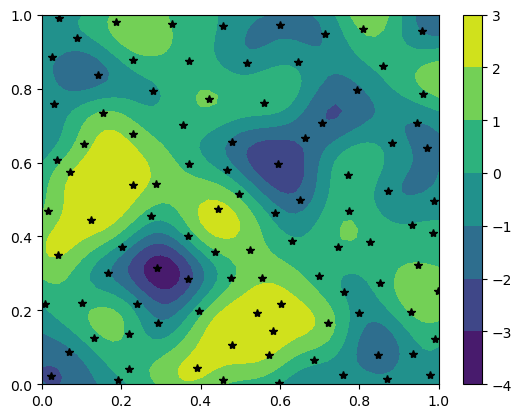

In [10]:
# Now making predictions on a finer grid
# Setting up the grid
n = 51
x1_test = torch.linspace(0,1,n)
x2_test = torch.linspace(0,1,n)
x1_test_grid, x2_test_grid = torch.meshgrid(x1_test,x2_test,indexing='ij')
X1_test = x1_test_grid.reshape(-1)
X2_test = x2_test_grid.reshape(-1)
X_test = torch.stack([X1_test,X2_test],dim=-1)
X_test_flipped = torch.stack([X2_test,X1_test],dim=-1)


# Get model into eval mode
model.eval()
likelihood.eval()

# Predicting
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))
    observed_pred_flipped = likelihood(model(X_test_flipped))


# Testing if predictions are equal
mean = observed_pred.mean
mean_flipped = observed_pred_flipped.mean
print(torch.equal(mean,mean_flipped)) # This returns True

# Plotting 
plt.contourf(x1_test_grid.numpy(),x2_test_grid.numpy(),mean.reshape(x1_test_grid.shape))
plt.colorbar()
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(model.variational_strategy.inducing_points.detach()[:,0],model.variational_strategy.inducing_points.detach()[:,1],'k*')

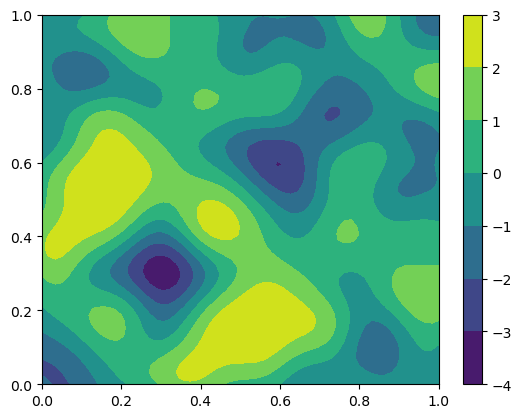

In [11]:
# Versus the true function

plt.contourf(x1_grid.numpy(),x2_grid.numpy(),f.reshape(x1_grid.shape))
plt.colorbar()
#plt.plot(X[:,0],X[:,1],'k*')

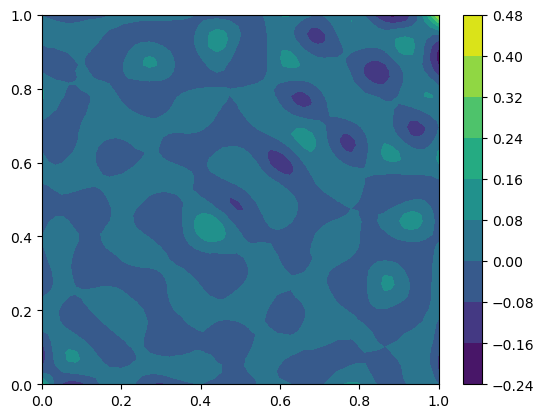

In [12]:
# And finally, let's look at the error surface
X_train_test = torch.stack([X1,X2],dim=-1)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_at_train = likelihood(model(X_train_test))

mean = test_at_train.mean
error = f-mean
plt.contourf(x1_grid.numpy(),x2_grid.numpy(),error.reshape(x1_grid.shape))
plt.colorbar()

### A more general version for any permutatation $\sigma(\{1,\ldots,p\})$

The permutation can be specified as a vector. For example $(4,1,2,5,3,0)$ is a permutation of the set $\{0,1,2,3,4,5\}$. We can use `torch.index_select` to permute the columns of the input matrix $X$ like we need, see below.

In [13]:
import torch 
X = torch.randn(10,5)
indices = torch.tensor([4,1,2])
print(X)
print(torch.index_select(X,1,indices)) # Pulls out the column in correct order

tensor([[ 0.3070, -1.8617, -0.0208, -0.9752, -1.2026],
        [-0.4466,  1.0755,  0.8505,  0.7012, -0.0691],
        [ 0.4285, -0.5227,  1.2505,  0.7024, -0.2820],
        [-0.9865,  0.4808, -0.5643, -0.8773, -0.7230],
        [ 0.4680, -1.4328, -0.4293,  0.7564,  1.0450],
        [ 0.7113,  1.0770,  0.2604, -0.1133,  0.7479],
        [-0.3954, -0.6801,  1.8016,  0.8169,  0.2061],
        [ 1.3323,  0.1010,  0.4421,  0.8211,  0.7351],
        [-0.7204, -0.5785,  0.2146, -0.5991, -0.1678],
        [ 0.2885, -1.3790, -0.8227,  0.1859,  0.7625]])
tensor([[-1.2026, -1.8617, -0.0208],
        [-0.0691,  1.0755,  0.8505],
        [-0.2820, -0.5227,  1.2505],
        [-0.7230,  0.4808, -0.5643],
        [ 1.0450, -1.4328, -0.4293],
        [ 0.7479,  1.0770,  0.2604],
        [ 0.2061, -0.6801,  1.8016],
        [ 0.7351,  0.1010,  0.4421],
        [-0.1678, -0.5785,  0.2146],
        [ 0.7625, -1.3790, -0.8227]])


We can build a more general version of `PermutationInvariantVariationalStrategy` that does this for us, it takes as input an additional argument `permutation` which is a `torch.tensor` of integers that specifies the permutation the function should be invariant to.

In [36]:
# Lets first set up our own Variational Strategy, just so we can see the flow of things:
# just copy and paste in the default one with a new name:
from typing import  Any, Dict, Iterable, Optional, Tuple
from torch import Tensor
from linear_operator import to_dense
from linear_operator.operators import (
    CholLinearOperator,
    DiagLinearOperator,
    LinearOperator,
    MatmulLinearOperator,
    RootLinearOperator,
    SumLinearOperator,
    TriangularLinearOperator,
)
from linear_operator.utils.cholesky import psd_safe_cholesky
from linear_operator.utils.errors import NotPSDError
from gpytorch.distributions import MultivariateNormal
from gpytorch.settings import _linalg_dtype_cholesky, trace_mode

def _ensure_updated_strategy_flag_set(
    state_dict: Dict[str, Tensor],
    prefix: str,
    local_metadata: Dict[str, Any],
    strict: bool,
    missing_keys: Iterable[str],
    unexpected_keys: Iterable[str],
    error_msgs: Iterable[str],
):
    device = state_dict[list(state_dict.keys())[0]].device
    if prefix + "updated_strategy" not in state_dict:
        state_dict[prefix + "updated_strategy"] = torch.tensor(False, device=device)
        warnings.warn(
            "You have loaded a variational GP model (using `VariationalStrategy`) from a previous version of "
            "GPyTorch. We have updated the parameters of your model to work with the new version of "
            "`VariationalStrategy` that uses whitened parameters.\nYour model will work as expected, but we "
            "recommend that you re-save your model.",
            OldVersionWarning,
        )

class PermutationInvariantVariationalStrategy(gpytorch.variational.VariationalStrategy):
    def __init__(self,
        model: gpytorch.models.ApproximateGP,
        inducing_points: torch.Tensor,
        variational_distribution: gpytorch.variational._VariationalDistribution,
        permutation: torch.Tensor,
        learn_inducing_locations: bool = True,
        jitter_val: Optional[float] = None,
    ):
        super().__init__(
            model, inducing_points, variational_distribution, learn_inducing_locations, jitter_val=jitter_val
        )
        self.register_buffer("updated_strategy", torch.tensor(True))
        self._register_load_state_dict_pre_hook(_ensure_updated_strategy_flag_set)
        self.has_fantasy_strategy = True
        ## TODO add a check to see if permutation is valid
        self.permutation = permutation
    
    def forward(
        self,
        x: Tensor,
        inducing_points: Tensor,
        inducing_values: Tensor,
        variational_inducing_covar: Optional[LinearOperator] = None,
        **kwargs,
    ) -> MultivariateNormal:
        # Compute full prior distribution
        full_inputs = torch.cat([inducing_points, x, torch.index_select(x,1,self.permutation)], dim=-2)
        #full_inputs_flipped = torch.cat([inducing_points, torch.index_select(x,1,self.permutation)],dim=-2)        
        #full_inputs_flipped_flipped = torch.cat([x,torch.index_select(x,1,self.permutation)],dim=-2)
        full_output = self.model.forward(full_inputs, **kwargs)
        #full_output_flipped = self.model.forward(full_inputs_flipped, **kwargs)
        #full_output_flipped_flipped = self.model.forward(full_inputs_flipped_flipped, **kwargs)
        full_covar = full_output.lazy_covariance_matrix
        #full_covar_flipped = full_output_flipped.lazy_covariance_matrix
        #full_covar_flipped_flipped = full_output_flipped_flipped.lazy_covariance_matrix

        # Covariance terms
        num_induc = inducing_points.size(-2)
        num_x = x.size(-2)
        test_mean = full_output.mean[..., num_induc:(num_induc+num_x)]
        induc_induc_covar = full_covar[..., :num_induc, :num_induc].add_jitter(self.jitter_val)
        #induc_data_covar = full_covar[..., :num_induc, num_induc:].to_dense()
        induc_data_covar = (full_covar[..., :num_induc, num_induc:(num_induc+num_x)] + 
                            full_covar[..., :num_induc, (num_induc+num_x):]).to_dense()
        #data_data_covar = full_covar[..., num_induc:, num_induc:]
        data_data_covar = (full_covar[..., num_induc:(num_induc+num_x), num_induc:(num_induc+num_x)] +
                           full_covar[..., num_induc:(num_induc+num_x), (num_induc+num_x):] +
                           full_covar[..., (num_induc+num_x):, num_induc:(num_induc+num_x)] +
                           full_covar[..., (num_induc+num_x):, (num_induc+num_x):])

        # Compute interpolation terms
        # K_ZZ^{-1/2} K_ZX
        # K_ZZ^{-1/2} \mu_Z
        L = self._cholesky_factor(induc_induc_covar)
        if L.shape != induc_induc_covar.shape:
            # Aggressive caching can cause nasty shape incompatibilies when evaluating with different batch shapes
            # TODO: Use a hook fo this
            try:
                pop_from_cache_ignore_args(self, "cholesky_factor")
            except CachingError:
                pass
            L = self._cholesky_factor(induc_induc_covar)
        interp_term = L.solve(induc_data_covar.type(_linalg_dtype_cholesky.value())).to(full_inputs.dtype)

        # Compute the mean of q(f)
        # k_XZ K_ZZ^{-1/2} (m - K_ZZ^{-1/2} \mu_Z) + \mu_X
        predictive_mean = (interp_term.transpose(-1, -2) @ inducing_values.unsqueeze(-1)).squeeze(-1) + test_mean

        # Compute the covariance of q(f)
        # K_XX + k_XZ K_ZZ^{-1/2} (S - I) K_ZZ^{-1/2} k_ZX
        middle_term = self.prior_distribution.lazy_covariance_matrix.mul(-1)
        if variational_inducing_covar is not None:
            middle_term = SumLinearOperator(variational_inducing_covar, middle_term)

        if trace_mode.on():
            predictive_covar = (
                data_data_covar.add_jitter(self.jitter_val).to_dense()
                + interp_term.transpose(-1, -2) @ middle_term.to_dense() @ interp_term
            )
        else:
            predictive_covar = SumLinearOperator(
                data_data_covar.add_jitter(self.jitter_val),
                MatmulLinearOperator(interp_term.transpose(-1, -2), middle_term @ interp_term),
            )

        # Return the distribution
        return MultivariateNormal(predictive_mean, predictive_covar)

Now let's set up a function that is symmetric in two of it's arguments, but not in the others. For example,
$$
f(x_1,x_2,x_3,x_4) = f(x_2,x_1,x_3,x_4)
$$

which is symmetric in $(x_1,x_2)$ but not in $(x_3,x_4)$

In [37]:
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

# Setting up the grid
n = 11
x1 = torch.linspace(0,1,n)
x2 = torch.linspace(0,1,n)
x3 = torch.linspace(0,1,n)
x4 = torch.linspace(0,1,n)
x1_grid, x2_grid, x3_grid, x4_grid = torch.meshgrid(x1,x2,x3,x4,indexing='ij')
X1 = x1_grid.reshape(-1)
X2 = x2_grid.reshape(-1)
X3 = x3_grid.reshape(-1)
X4 = x4_grid.reshape(-1)
X = torch.stack([X1,X2,X3,X4],dim=-1)
X_flipped = torch.stack([X2,X1,X3,X4],dim=-1)

# Generating a random sample from a GP
mean = gpytorch.means.ZeroMean()
covar = gpytorch.kernels.RBFKernel()
covar.lengthscale = 0.1
m = mean(X)
K = (covar(X,X) + covar(X,X_flipped) + covar(X_flipped,X) + covar(X_flipped,X_flipped)).add_jitter().evaluate()
GP = gpytorch.distributions.MultivariateNormal(m,K)
f = GP.rsample().detach()


# Now generate some corresponding data
sigma = 0.01
y = f + sigma*torch.randn(f.size())


# Finally, going to drop a proportion of the data just to ensure the grid structure is broken and 
# the model will find it difficult to learn the exact invariance.
k = 2000
perm = torch.randperm(y.size(0))
idx = perm[:k]
y = y[idx]
X = X[idx,:]





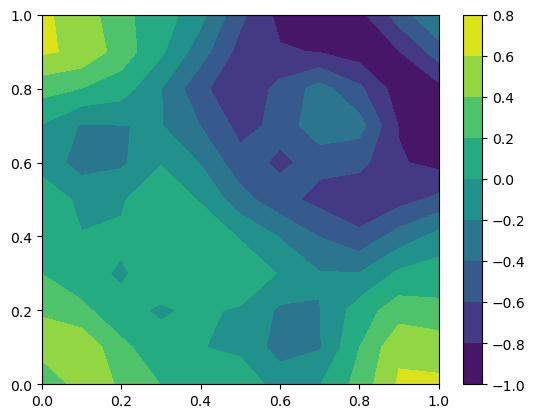

In [38]:
# Do plotting here so we don't generate a new sample everytime
# These plots should look symmetric
slice3 = 5
slice4 = 0
plt.contourf(x1_grid[:,:,slice3,slice4].numpy(),x2_grid[:,:,slice3,slice4].numpy(),f.reshape(x1_grid.shape)[:,:,slice3,slice4])
plt.colorbar()

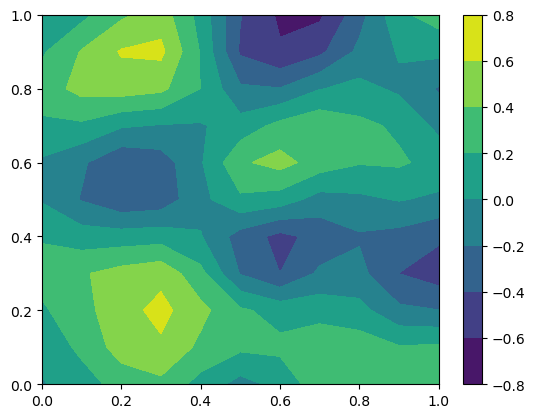

In [39]:
# Do plotting here so we don't generate a new sample everytime
# These should not necessarily be symmetric
slice1 = 6
slice2 = 0
plt.contourf(x3_grid[slice1,slice2,:,:].numpy(),x4_grid[slice1,slice2,:,:].numpy(),f.reshape(x3_grid.shape)[slice1,slice2,:,:])
plt.colorbar()

In [40]:
X.shape

torch.Size([2000, 4])

Set up the model and keep in mind to define the permutation

In [41]:
# And now define the approximate model, nothing invariant going on here
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        permutation = torch.tensor([1,0,2,3])
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = PermutationInvariantVariationalStrategy(self,inducing_points,variational_distribution,
                                                                       permutation=permutation,
                                                                       learn_inducing_locations=True)
        super(GPModel,self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)
    
num_inducing_points = 500
inducing_points = torch.rand(num_inducing_points,4)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [43]:
# Set up optimization scheme

# Number of iterations of optimizer
training_iter = 4000

# Set model in train
model.train()
likelihood.train()
# Optimizeer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.005)
# Define loss function
mll = gpytorch.mlls.VariationalELBO(likelihood,model,num_data = y.size(0))

# Keeping track of loss
m = []
eps = 1e-6
diff = 10

# Then train
for i in range(training_iter):
    # Zero gradients
    optimizer.zero_grad()
    # Output from model 
    output = model(X)
    # Calculate loss
    loss = -mll(output,y)
    loss.backward()
    m.append(loss.item())
    if i > 0:
        diff = abs(m[i]-m[i-1])
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f loss difference: %.4f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        likelihood.noise.item(),
        diff
    ))
    optimizer.step()
    if diff < eps:
        print('Model converged!')
        break

Iter 1/4000 - Loss: -0.019   lengthscale: 0.261   noise: 0.033 loss difference: 10.0000
Iter 2/4000 - Loss: 1.050   lengthscale: 0.262   noise: 0.033 loss difference: 1.0693
Iter 3/4000 - Loss: 0.089   lengthscale: 0.261   noise: 0.033 loss difference: 0.9610
Iter 4/4000 - Loss: 0.206   lengthscale: 0.261   noise: 0.033 loss difference: 0.1166
Iter 5/4000 - Loss: 0.433   lengthscale: 0.260   noise: 0.033 loss difference: 0.2274
Iter 6/4000 - Loss: 0.338   lengthscale: 0.260   noise: 0.033 loss difference: 0.0952
Iter 7/4000 - Loss: 0.177   lengthscale: 0.260   noise: 0.034 loss difference: 0.1607
Iter 8/4000 - Loss: 0.102   lengthscale: 0.260   noise: 0.034 loss difference: 0.0759
Iter 9/4000 - Loss: 0.110   lengthscale: 0.260   noise: 0.034 loss difference: 0.0081
Iter 10/4000 - Loss: 0.142   lengthscale: 0.260   noise: 0.034 loss difference: 0.0325
Iter 11/4000 - Loss: 0.151   lengthscale: 0.260   noise: 0.034 loss difference: 0.0087
Iter 12/4000 - Loss: 0.127   lengthscale: 0.260   

Iter 97/4000 - Loss: -0.029   lengthscale: 0.257   noise: 0.032 loss difference: 0.0002
Iter 98/4000 - Loss: -0.029   lengthscale: 0.256   noise: 0.032 loss difference: 0.0002
Iter 99/4000 - Loss: -0.029   lengthscale: 0.256   noise: 0.032 loss difference: 0.0002
Iter 100/4000 - Loss: -0.029   lengthscale: 0.256   noise: 0.032 loss difference: 0.0002
Iter 101/4000 - Loss: -0.030   lengthscale: 0.256   noise: 0.032 loss difference: 0.0002
Iter 102/4000 - Loss: -0.030   lengthscale: 0.256   noise: 0.032 loss difference: 0.0002
Iter 103/4000 - Loss: -0.030   lengthscale: 0.256   noise: 0.032 loss difference: 0.0002
Iter 104/4000 - Loss: -0.030   lengthscale: 0.256   noise: 0.032 loss difference: 0.0002
Iter 105/4000 - Loss: -0.030   lengthscale: 0.256   noise: 0.032 loss difference: 0.0002
Iter 106/4000 - Loss: -0.030   lengthscale: 0.256   noise: 0.031 loss difference: 0.0001
Iter 107/4000 - Loss: -0.030   lengthscale: 0.256   noise: 0.031 loss difference: 0.0001
Iter 108/4000 - Loss: -0

Iter 193/4000 - Loss: -0.042   lengthscale: 0.252   noise: 0.029 loss difference: 0.0001
Iter 194/4000 - Loss: -0.042   lengthscale: 0.252   noise: 0.029 loss difference: 0.0001
Iter 195/4000 - Loss: -0.042   lengthscale: 0.252   noise: 0.029 loss difference: 0.0001
Iter 196/4000 - Loss: -0.042   lengthscale: 0.252   noise: 0.029 loss difference: 0.0001
Iter 197/4000 - Loss: -0.042   lengthscale: 0.252   noise: 0.029 loss difference: 0.0001
Iter 198/4000 - Loss: -0.043   lengthscale: 0.251   noise: 0.029 loss difference: 0.0001
Iter 199/4000 - Loss: -0.043   lengthscale: 0.251   noise: 0.029 loss difference: 0.0001
Iter 200/4000 - Loss: -0.043   lengthscale: 0.251   noise: 0.029 loss difference: 0.0001
Iter 201/4000 - Loss: -0.043   lengthscale: 0.251   noise: 0.029 loss difference: 0.0001
Iter 202/4000 - Loss: -0.043   lengthscale: 0.251   noise: 0.029 loss difference: 0.0001
Iter 203/4000 - Loss: -0.043   lengthscale: 0.251   noise: 0.029 loss difference: 0.0001
Iter 204/4000 - Loss:

Iter 288/4000 - Loss: -0.054   lengthscale: 0.246   noise: 0.027 loss difference: 0.0001
Iter 289/4000 - Loss: -0.054   lengthscale: 0.246   noise: 0.027 loss difference: 0.0001
Iter 290/4000 - Loss: -0.055   lengthscale: 0.246   noise: 0.027 loss difference: 0.0001
Iter 291/4000 - Loss: -0.055   lengthscale: 0.246   noise: 0.027 loss difference: 0.0001
Iter 292/4000 - Loss: -0.055   lengthscale: 0.246   noise: 0.027 loss difference: 0.0001
Iter 293/4000 - Loss: -0.055   lengthscale: 0.246   noise: 0.027 loss difference: 0.0001
Iter 294/4000 - Loss: -0.055   lengthscale: 0.246   noise: 0.027 loss difference: 0.0001
Iter 295/4000 - Loss: -0.055   lengthscale: 0.246   noise: 0.027 loss difference: 0.0001
Iter 296/4000 - Loss: -0.055   lengthscale: 0.246   noise: 0.027 loss difference: 0.0001
Iter 297/4000 - Loss: -0.055   lengthscale: 0.245   noise: 0.027 loss difference: 0.0001
Iter 298/4000 - Loss: -0.056   lengthscale: 0.245   noise: 0.027 loss difference: 0.0001
Iter 299/4000 - Loss:

Iter 383/4000 - Loss: -0.066   lengthscale: 0.240   noise: 0.026 loss difference: 0.0001
Iter 384/4000 - Loss: -0.066   lengthscale: 0.240   noise: 0.026 loss difference: 0.0001
Iter 385/4000 - Loss: -0.066   lengthscale: 0.240   noise: 0.026 loss difference: 0.0001
Iter 386/4000 - Loss: -0.067   lengthscale: 0.240   noise: 0.026 loss difference: 0.0001
Iter 387/4000 - Loss: -0.067   lengthscale: 0.240   noise: 0.026 loss difference: 0.0001
Iter 388/4000 - Loss: -0.067   lengthscale: 0.239   noise: 0.026 loss difference: 0.0001
Iter 389/4000 - Loss: -0.067   lengthscale: 0.239   noise: 0.026 loss difference: 0.0001
Iter 390/4000 - Loss: -0.067   lengthscale: 0.239   noise: 0.026 loss difference: 0.0001
Iter 391/4000 - Loss: -0.067   lengthscale: 0.239   noise: 0.026 loss difference: 0.0001
Iter 392/4000 - Loss: -0.067   lengthscale: 0.239   noise: 0.026 loss difference: 0.0001
Iter 393/4000 - Loss: -0.067   lengthscale: 0.239   noise: 0.026 loss difference: 0.0001
Iter 394/4000 - Loss:

Iter 479/4000 - Loss: -0.077   lengthscale: 0.234   noise: 0.025 loss difference: 0.0001
Iter 480/4000 - Loss: -0.078   lengthscale: 0.233   noise: 0.025 loss difference: 0.0001
Iter 481/4000 - Loss: -0.078   lengthscale: 0.233   noise: 0.025 loss difference: 0.0001
Iter 482/4000 - Loss: -0.078   lengthscale: 0.233   noise: 0.025 loss difference: 0.0001
Iter 483/4000 - Loss: -0.078   lengthscale: 0.233   noise: 0.025 loss difference: 0.0001
Iter 484/4000 - Loss: -0.078   lengthscale: 0.233   noise: 0.025 loss difference: 0.0001
Iter 485/4000 - Loss: -0.078   lengthscale: 0.233   noise: 0.025 loss difference: 0.0001
Iter 486/4000 - Loss: -0.078   lengthscale: 0.233   noise: 0.025 loss difference: 0.0001
Iter 487/4000 - Loss: -0.078   lengthscale: 0.233   noise: 0.025 loss difference: 0.0001
Iter 488/4000 - Loss: -0.078   lengthscale: 0.233   noise: 0.025 loss difference: 0.0001
Iter 489/4000 - Loss: -0.079   lengthscale: 0.233   noise: 0.025 loss difference: 0.0001
Iter 490/4000 - Loss:

Iter 575/4000 - Loss: -0.088   lengthscale: 0.228   noise: 0.025 loss difference: 0.0001
Iter 576/4000 - Loss: -0.088   lengthscale: 0.228   noise: 0.025 loss difference: 0.0001
Iter 577/4000 - Loss: -0.088   lengthscale: 0.228   noise: 0.025 loss difference: 0.0001
Iter 578/4000 - Loss: -0.088   lengthscale: 0.228   noise: 0.024 loss difference: 0.0001
Iter 579/4000 - Loss: -0.089   lengthscale: 0.227   noise: 0.024 loss difference: 0.0001
Iter 580/4000 - Loss: -0.089   lengthscale: 0.227   noise: 0.024 loss difference: 0.0001
Iter 581/4000 - Loss: -0.089   lengthscale: 0.227   noise: 0.024 loss difference: 0.0001
Iter 582/4000 - Loss: -0.089   lengthscale: 0.227   noise: 0.024 loss difference: 0.0001
Iter 583/4000 - Loss: -0.089   lengthscale: 0.227   noise: 0.024 loss difference: 0.0001
Iter 584/4000 - Loss: -0.089   lengthscale: 0.227   noise: 0.024 loss difference: 0.0001
Iter 585/4000 - Loss: -0.089   lengthscale: 0.227   noise: 0.024 loss difference: 0.0001
Iter 586/4000 - Loss:

Iter 670/4000 - Loss: -0.097   lengthscale: 0.223   noise: 0.024 loss difference: 0.0001
Iter 671/4000 - Loss: -0.097   lengthscale: 0.223   noise: 0.024 loss difference: 0.0001
Iter 672/4000 - Loss: -0.097   lengthscale: 0.223   noise: 0.024 loss difference: 0.0001
Iter 673/4000 - Loss: -0.098   lengthscale: 0.223   noise: 0.024 loss difference: 0.0001
Iter 674/4000 - Loss: -0.098   lengthscale: 0.223   noise: 0.024 loss difference: 0.0001
Iter 675/4000 - Loss: -0.098   lengthscale: 0.223   noise: 0.024 loss difference: 0.0001
Iter 676/4000 - Loss: -0.098   lengthscale: 0.223   noise: 0.024 loss difference: 0.0001
Iter 677/4000 - Loss: -0.098   lengthscale: 0.222   noise: 0.024 loss difference: 0.0001
Iter 678/4000 - Loss: -0.098   lengthscale: 0.222   noise: 0.024 loss difference: 0.0001
Iter 679/4000 - Loss: -0.098   lengthscale: 0.222   noise: 0.024 loss difference: 0.0001
Iter 680/4000 - Loss: -0.098   lengthscale: 0.222   noise: 0.024 loss difference: 0.0001
Iter 681/4000 - Loss:

Iter 766/4000 - Loss: -0.105   lengthscale: 0.219   noise: 0.023 loss difference: 0.0001
Iter 767/4000 - Loss: -0.105   lengthscale: 0.219   noise: 0.023 loss difference: 0.0001
Iter 768/4000 - Loss: -0.105   lengthscale: 0.219   noise: 0.023 loss difference: 0.0001
Iter 769/4000 - Loss: -0.105   lengthscale: 0.219   noise: 0.023 loss difference: 0.0001
Iter 770/4000 - Loss: -0.105   lengthscale: 0.219   noise: 0.023 loss difference: 0.0001
Iter 771/4000 - Loss: -0.105   lengthscale: 0.219   noise: 0.023 loss difference: 0.0001
Iter 772/4000 - Loss: -0.105   lengthscale: 0.219   noise: 0.023 loss difference: 0.0001
Iter 773/4000 - Loss: -0.105   lengthscale: 0.219   noise: 0.023 loss difference: 0.0000
Iter 774/4000 - Loss: -0.105   lengthscale: 0.219   noise: 0.023 loss difference: 0.0000
Iter 775/4000 - Loss: -0.105   lengthscale: 0.219   noise: 0.023 loss difference: 0.0000
Iter 776/4000 - Loss: -0.105   lengthscale: 0.218   noise: 0.023 loss difference: 0.0000
Iter 777/4000 - Loss:

Iter 861/4000 - Loss: -0.110   lengthscale: 0.216   noise: 0.022 loss difference: 0.0000
Iter 862/4000 - Loss: -0.110   lengthscale: 0.216   noise: 0.022 loss difference: 0.0000
Iter 863/4000 - Loss: -0.111   lengthscale: 0.216   noise: 0.022 loss difference: 0.0000
Iter 864/4000 - Loss: -0.111   lengthscale: 0.216   noise: 0.022 loss difference: 0.0000
Iter 865/4000 - Loss: -0.111   lengthscale: 0.216   noise: 0.022 loss difference: 0.0001
Iter 866/4000 - Loss: -0.111   lengthscale: 0.216   noise: 0.022 loss difference: 0.0001
Iter 867/4000 - Loss: -0.111   lengthscale: 0.216   noise: 0.022 loss difference: 0.0001
Iter 868/4000 - Loss: -0.111   lengthscale: 0.216   noise: 0.022 loss difference: 0.0001
Iter 869/4000 - Loss: -0.111   lengthscale: 0.216   noise: 0.022 loss difference: 0.0001
Iter 870/4000 - Loss: -0.111   lengthscale: 0.216   noise: 0.022 loss difference: 0.0001
Iter 871/4000 - Loss: -0.111   lengthscale: 0.216   noise: 0.022 loss difference: 0.0000
Iter 872/4000 - Loss:

Iter 956/4000 - Loss: -0.114   lengthscale: 0.214   noise: 0.022 loss difference: 0.0000
Iter 957/4000 - Loss: -0.114   lengthscale: 0.214   noise: 0.022 loss difference: 0.0000
Iter 958/4000 - Loss: -0.114   lengthscale: 0.214   noise: 0.022 loss difference: 0.0000
Iter 959/4000 - Loss: -0.115   lengthscale: 0.214   noise: 0.022 loss difference: 0.0000
Iter 960/4000 - Loss: -0.115   lengthscale: 0.214   noise: 0.022 loss difference: 0.0001
Iter 961/4000 - Loss: -0.115   lengthscale: 0.214   noise: 0.022 loss difference: 0.0001
Iter 962/4000 - Loss: -0.115   lengthscale: 0.214   noise: 0.022 loss difference: 0.0001
Iter 963/4000 - Loss: -0.115   lengthscale: 0.214   noise: 0.022 loss difference: 0.0001
Iter 964/4000 - Loss: -0.115   lengthscale: 0.214   noise: 0.022 loss difference: 0.0001
Iter 965/4000 - Loss: -0.115   lengthscale: 0.213   noise: 0.022 loss difference: 0.0000
Iter 966/4000 - Loss: -0.115   lengthscale: 0.213   noise: 0.022 loss difference: 0.0000
Iter 967/4000 - Loss:

Iter 1051/4000 - Loss: -0.118   lengthscale: 0.212   noise: 0.022 loss difference: 0.0001
Iter 1052/4000 - Loss: -0.117   lengthscale: 0.212   noise: 0.022 loss difference: 0.0002
Iter 1053/4000 - Loss: -0.117   lengthscale: 0.212   noise: 0.022 loss difference: 0.0005
Iter 1054/4000 - Loss: -0.116   lengthscale: 0.212   noise: 0.022 loss difference: 0.0006
Iter 1055/4000 - Loss: -0.116   lengthscale: 0.212   noise: 0.022 loss difference: 0.0002
Iter 1056/4000 - Loss: -0.117   lengthscale: 0.212   noise: 0.022 loss difference: 0.0007
Iter 1057/4000 - Loss: -0.118   lengthscale: 0.212   noise: 0.022 loss difference: 0.0010
Iter 1058/4000 - Loss: -0.118   lengthscale: 0.212   noise: 0.022 loss difference: 0.0002
Iter 1059/4000 - Loss: -0.117   lengthscale: 0.212   noise: 0.022 loss difference: 0.0005
Iter 1060/4000 - Loss: -0.117   lengthscale: 0.212   noise: 0.022 loss difference: 0.0002
Iter 1061/4000 - Loss: -0.118   lengthscale: 0.212   noise: 0.022 loss difference: 0.0005
Iter 1062/

In [44]:
# Now making predictions on a finer grid
# Setting up the grid
n = 21
x1_test = torch.linspace(0,1,n)
x2_test = torch.linspace(0,1,n)
x3_test = torch.linspace(0,1,n)
x4_test = torch.linspace(0,1,n)
x1_test_grid, x2_test_grid, x3_test_grid, x4_test_grid = torch.meshgrid(x1_test,x2_test,x3_test,x4_test,indexing='ij')
X1_test = x1_test_grid.reshape(-1)
X2_test = x2_test_grid.reshape(-1)
X3_test = x3_test_grid.reshape(-1)
X4_test = x4_test_grid.reshape(-1)
X_test = torch.stack([X1_test,X2_test,X3_test,X4_test],dim=-1)
X_test_flipped = torch.stack([X2_test,X1_test,X3_test,X4_test],dim=-1)


# Get model into eval mode
model.eval()
likelihood.eval()

# Predicting
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))
    observed_pred_flipped = likelihood(model(X_test_flipped))


# Testing if predictions are equal
mean = observed_pred.mean
mean_flipped = observed_pred_flipped.mean
print(torch.equal(mean,mean_flipped)) # This returns True


True


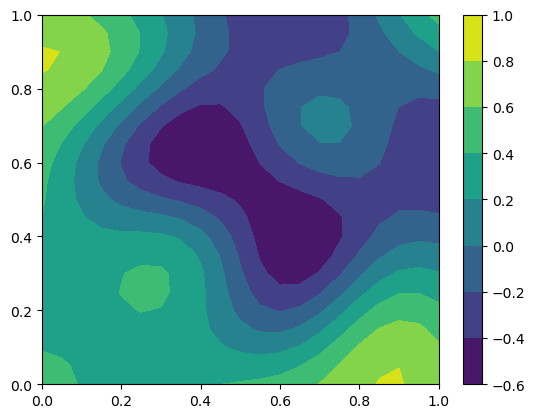

In [45]:
# Plotting 
# These plots should look symmetric
slice3 = 5
slice4 = 0
plt.contourf(x1_test_grid[:,:,slice3,slice4].numpy(),x2_test_grid[:,:,slice3,slice4].numpy(),mean.reshape(x1_test_grid.shape)[:,:,slice3,slice4])
plt.colorbar()
#plt.xlim(0,1)
#plt.ylim(0,1)
#plt.plot(model.variational_strategy.inducing_points.detach()[:,0],model.variational_strategy.inducing_points.detach()[:,1],'k*')

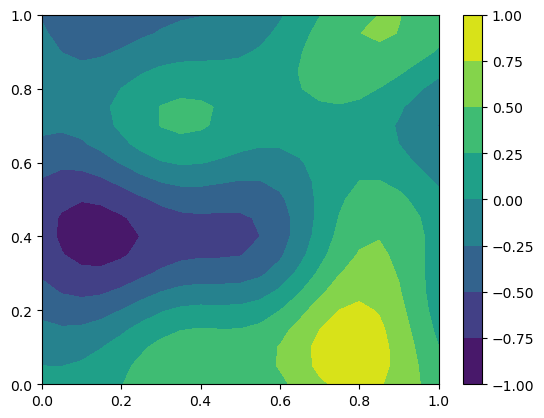

In [46]:
# These should not necessarily be symmetric
slice1 = 6
slice2 = 0
plt.contourf(x3_test_grid[slice1,slice2,:,:].numpy(),x4_test_grid[slice1,slice2,:,:].numpy(),mean.reshape(x3_test_grid.shape)[slice1,slice2,:,:])
plt.colorbar()